In [2]:
from astropy.io import fits,ascii
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import sys
import warnings
warnings.filterwarnings('ignore')
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.stats import ks_2samp
from astropy import units as u

In [3]:
homedir = os.getenv("HOME")
sys.path.append(homedir+'/github/APPSS/')
from a100sdss import ks, anderson
sys.path.append(homedir+'/github/LCS/python/Python3/')
from LCScommon import *

Running on coma


In [4]:
plotdir = homedir+'/research/LCS/plots/'


In [5]:
def sfr_mstar(flags,colorvar,plotbinned=True,v1=.1,v2=1):

    plt.figure(figsize=(14,4))
    all_axes=[]
    for i in range(len(flags)):
        plt.subplot(1,3,i+1)
        plt.scatter(mstar[flags[i]],sfr[flags[i]],c=colorvar[flags[i]],vmin=v1,vmax=v2)
        if i > 0:
            plt.yticks([])
        plt.axis([8,12,-2,1])
        all_axes.append(plt.gca())
        xl = np.linspace(8,12,100)
        # chi by eye split b/w SF and quiescent
        yl = -11.8 + xl
        plt.plot(xl,yl,'k--')
        # chi by eye fit to main sequence in field
        yl = -10.4 + xl
        plt.plot(xl,yl,'k-')
        if plotbinned:
            xbin,ybin,ybinerr= binxycolor(mstar[flags[i]& sf_flag],sfr[flags[i]& sf_flag],colorvar[flags[i] & sf_flag],6,use_median=True)
 
            plt.scatter(xbin,ybin,c=ybinerr,s=300,vmin=v1,vmax=v2,marker='s')
    plt.colorbar(ax=all_axes)
    
def size_vs_size(flags,colorvar,plotbinned=True,v1=1,v2=10):
    xmin=0
    xmax=15
    plt.figure(figsize=(14,4))
    all_axes=[]
    for i in range(len(flags)):
        plt.subplot(1,3,i+1)
        #plt.scatter(g.s['Rd'][flags[i]],g.s['fre1'][flags[i]],c=colorvar[flags[i]],vmin=v1,vmax=v2)
        plt.scatter(g.s['Rd'][flags[i]],g.s['fre1'][flags[i]],c=colorvar[flags[i]],vmin=v1,vmax=v2)
        if i > 0:
            plt.yticks([])
        plt.axis([xmin,xmax,xmin,xmax])
        #plt.gca().set_xscale('log')
        #plt.gca().set_yscale('log')
        all_axes.append(plt.gca())
        xl = np.linspace(xmin,xmax,100)
        # chi by eye split b/w SF and quiescent
        #yl = -11.8 + xl
        plt.plot(xl,xl,'k--')
        # chi by eye fit to main sequence in field
        #yl = -10.4 + xl
        #plt.plot(xl,yl,'k-')
        if plotbinned:
            xbin,ybin,ybinerr= binxycolor(mstar[flags[i]& sf_flag],sfr[flags[i]& sf_flag],colorvar[flags[i] & sf_flag],6,use_median=True)
 
            plt.scatter(xbin,ybin,c=ybinerr,s=300,vmin=v1,vmax=v2,marker='s')
    plt.colorbar(ax=all_axes)


# Generating the LCS Catalog #

- this is done in LCSbase.py
- this calculates the SFRs according to the Kennicutt & Evans prescriptions
- I have corrected the NSA magnitudes to the WMAP 9 cosmology

In [181]:
%run ~/github/LCS/python/Python3/LCSbase.py

nothing happening here
(1800, 1800)
updating table


# Comparison of LCS with GSWLC #

- The GSWLC provides a better comparison sample for us.
- I matched to GSWLC-X2 - used 5 arcsecond radius.  found 1496 matches.
  - I didn't note how I did the match.  I don't see any python programs, so I probably used topcat.
  - redoing on 5/29/20
  - matching LCS_all_size_KE_SFR.fits with GSWLC-X2-LCS-Zoverlap.dat
  - matching NSA RA,DEC with GSWLC RA,DEC
    - 5 arcsec offset
    - best match, symmetric
    - 1 and 2
    - found 1477 pairs (~20 fewer than last time :( )
   - 10 arcsec search radius
     - 1487 pairs
   - 15 arcsec search radius
     - 1490 pairs - LCS_all_size_KE_SFR_GSWLC2_X2.fits
- we can use the GSWLC SFRs and Stellar masses for both the LCS and comparison galaxies.  This removes significant uncertainty associated with mixing methods for calculating SFR and Mstar.

- redshift limit $0.01 < z < 0.03$
- mag limit r petrosian $r = 18.0$
- main sequence: $log10(sSFR) > -11$
- explanation of GSWLC-2 catalog http://pages.iu.edu/~salims/gswlc/table2.pdf

**Stellar Mass Limit**

- convert r to Mr at maximum distance of LCS ($z=.0433$)
- then plot Mstar vs Mr, and estimate Mstar limit from Mr limit

**SFR Limit**
- Salim+2018 use $log10(sSFR) > -11$ to select star-forming galaxies
- $log10(sSFR) < -11.5$ should be considered upper limits GSWLC-A (Salim+2018, pg 11, col2)
  - we use this as our sSFR limit
- for SF galaxies, SFR errors are typically below 0.1dex

**Environment Catalogs**
- yang+07
- tempel+2012 - http://www.aai.ee/~elmo/dr8groups/readme.txt
- decarvalha+2017

In [30]:
# this catalog is a joined catalog between LCS and GSWLC
# it contains 1505 rows - the number of matches b/w the two catalogs

# as of Aug 2020, I am not sure how this catalog was created
# in my notes above, I say how LCS_all_size_KE_SFR_GSWLC2_X2.fits was created
lcsgsw = fits.getdata('/home/rfinn/research/LCS/tables/lcs-gswlc-x2-match.fits')
#lcsgsw['sampleflag'] = lcsgsw['sampleflag'] == 84

In [31]:
print('number of matches between LCS and GSWLC = ',len(lcsgsw))
print('number with UV = ',sum(lcsgsw['flag_uv'] == 2))
print('number with mid IR = ',sum(lcsgsw['flag_midir'] == 1))
print('number with SDSS galaxy data = ',sum(lcsgsw['flag_mgs'] == 1))

number of matches between LCS and GSWLC =  1505
number with UV =  546
number with mid IR =  437
number with SDSS galaxy data =  1477


## Reviewing LCS core/external cut for paper2 ##

normalizing by radius of disk


No handles with labels found to put in legend.


<Figure size 489.6x360 with 0 Axes>

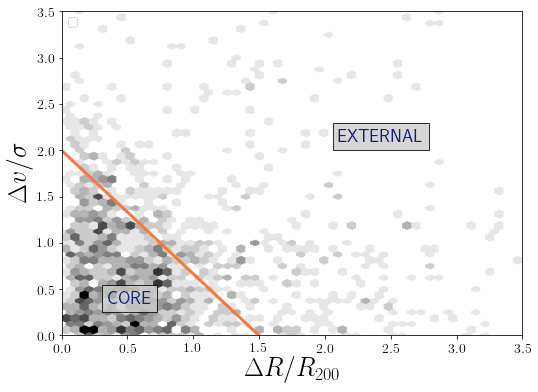

In [98]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
figname1 = homedir+'/research/LCS/plots/lcs-dvdr.png'
figname2 = homedir+'/research/LCS/plots/lcs-dvdr.pdf'
lcs.plot_dvdr(figname1=figname1,figname2=figname2)

# Creating Field Sample from Full GSWLC #

* for a quick test, use entire GSWLC catalog
* sort by local density first, then use group catalog from Temple+2014
  - measure local densities
  - cut GSWLC by local density to create a field sample
  - could also try matching to Yang catalog - see if it matters.
* tempel+2014 catlog can be downloaded from here ftp://cdsarc.u-strasbg.fr/pub/cats/J/A+A/566/A1


In [34]:
gsw = ascii.read('/home/rfinn/research/GSWLC/GSWLC-X2.dat')
gsw = gsw[((gsw['Z']*3.e5 < 13000.) & (gsw['logMstar']> 0))] 
print('number is GSWLC = ',len(gsw))

number is GSWLC =  65611


In [35]:
print(sum(gsw['flag_mgs']))

63521


cutting GSWLC to main SDSS survey area, and then recalculating local densities



normalizing by radius of disk


<Figure size 489.6x360 with 0 Axes>

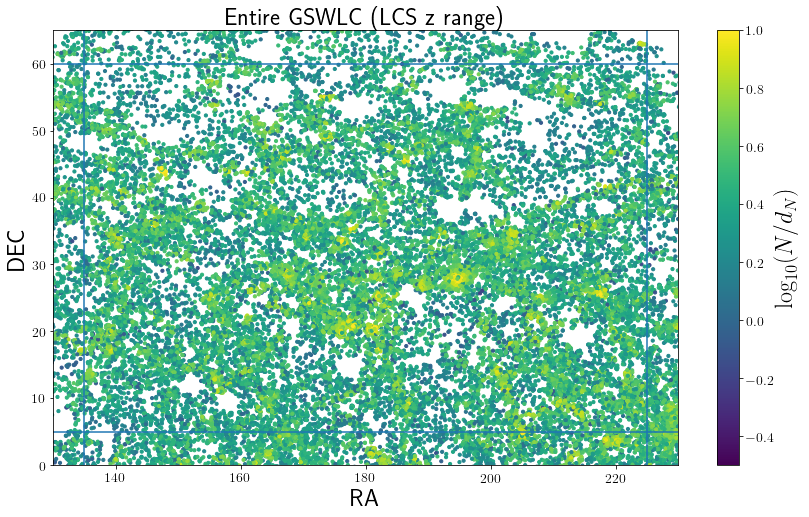

In [66]:
%run ~/github/LCS/python/Python3/lcs_paper2.py
figname1 = homedir+'/research/LCS/plots/gswlc-skyplot.png'
figname2 = homedir+'/research/LCS/plots/gswlc-skyplot.pdf'
g.plot_field1(figname1=figname1,figname2=figname2)

normalizing by radius of disk
median local density =  0.483


<Figure size 489.6x360 with 0 Axes>

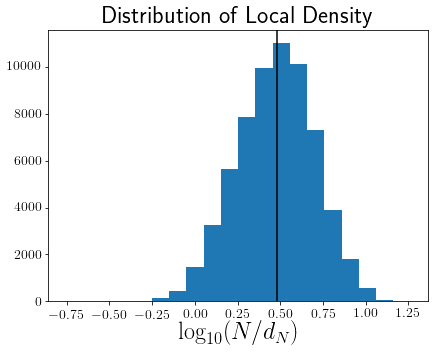

In [67]:
%run ~/github/LCS/python/Python3/lcs_paper2.py
figname1 = homedir+'/research/LCS/plots/gswlc-dens-hist.png'
figname2 = homedir+'/research/LCS/plots/gswlc-dens-hist.pdf'
g.plot_dens_hist(figname1=figname1,figname2=figname2)

Could also use Yang catalog to remove all galaxies in halos with log M_halo > 13.5 or 14




# Visualizing GSWLC sSFR Limit # 

Salim+2016 state that $sSFR < -11.5$ should be considered upper limits.

The goal of this figure is to visualize where the $sSFR > -11.5$ is relative to SF main sequence.  First need to see if we can show the sSFR of the main sequence.

The Figure below shows the Salim+07 fit to SF main sequence, minus 0.3 dex.  Apparently there is a normalization offset b/w Salim+07 and GSWLC from Salim+16.  The solid line is the mass-dependent fit to the MS, and the dashed line is a factor of 5 below the MS.  The function to plot the lines is from Greg.

    lssfr = -0.35*(lmstar - 10) - 9.83

    #use their equation 12 for color-selected galaxies including
    #AGN/SF composites.  This is for log(Mstar)>9.4
    #lssfr = -0.53*(lmstar - 10) - 9.87

    lsfr = lmstar + lssfr -.3
    sfr = 10.**lsfr

repeat above, but only keep galaxies in redshift range of LCS
so that we can judge the mass limit where we can probe SF a factor of 
5 (or N) below the main sequence



normalizing by radius of disk


<Figure size 489.6x360 with 0 Axes>

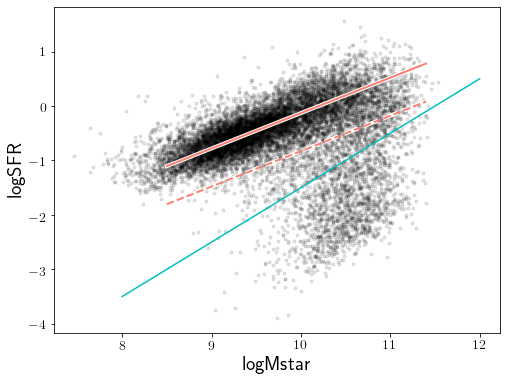

In [9]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
g.plot_ms()

# Determining the stellar mass limit of GSWLC+LCS#

Salim+2016 report $r=18$ limit.  This corresponds to $M_r = -18.3$ at the distance of our farthest cluster.  

We use the distribution of logMstar vs Mr to determine what stellar mass this corresponds to.  The answer is $logMstar = 9.8$.

Therefore, we cut the GSWLC and LCS samples at $logMstar (GSWLC) > 9.8$.

NOTE - we updated this in the second plot, but I can't remember why.  Maybe the Tempel sample has a different magnitude cut?

normalizing by radius of disk
0.0433
-18.342555555293856


<Figure size 489.6x360 with 0 Axes>

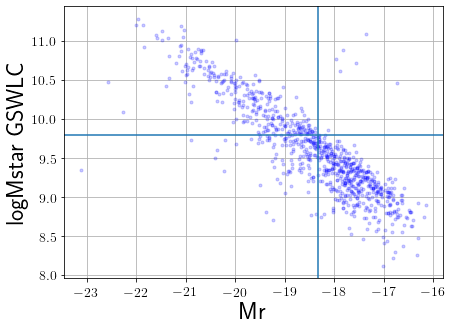

In [50]:
%run ~/github/LCS/python/Python3/lcs_paper2.py
lcs.get_mstar_limit()

normalizing by radius of disk
17.7 0.0433
-18.642555555293857


<Figure size 489.6x360 with 0 Axes>

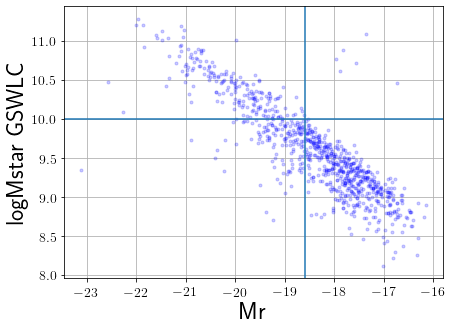

In [133]:
%run ~/github/LCS/python/Python3/lcs_paper2.py
lcs.get_mstar_limit()

# Comparing LCS vs GSWLC with correct mass and sSFR cuts #

According to Salim+2016, the mass limit is log10Mstar = 9.8, and the ssfr cut is -11.5.

When we apply these cuts and compare the LCS and GSWLC in the SFR-Mstar plane, the LCS galaxies have a similar distribution of stellar masses, but significantly lower SFRs.

We can also compare sSFRs.

normalizing by radius of disk
number in core sample =  137
number in external sample =  1096
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.10
p-vale = 0.14559 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.32
p-vale = 0.00000 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

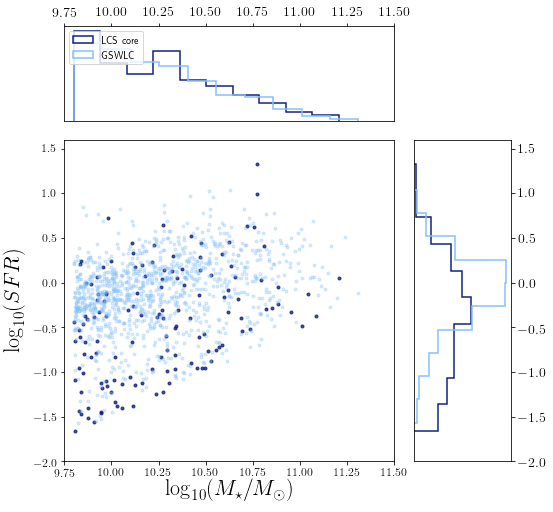

In [58]:
# cutting GSWLC by local density
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
b.plot_sfr_mstar()

normalizing by radius of disk
number in core sample =  92
number in external sample =  3599
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.12
p-vale = 0.13924 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   0.14
p-vale = 0.30142 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.29
p-vale = 0.00000 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  21.46
p-vale = 0.00001 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

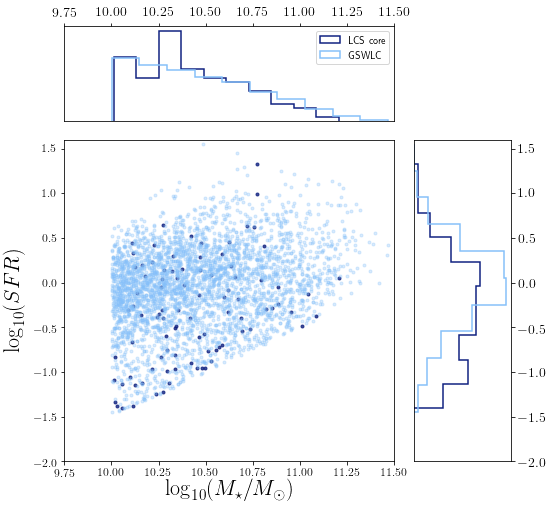

In [134]:
# cutting by halo mass: log(M) < 12.5
# mass limit log(M) > 9.9 (instead of 9.8)
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
b.plot_sfr_mstar()

### LCS Infall vs GSWLC Field ###

**CONCLUSION:**
- LCS infall galaxies have significantly lower SFRs

normalizing by radius of disk
number in core sample =  88
number in external sample =  3599
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.12
p-vale = 0.16472 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.20
p-vale = 0.00196 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

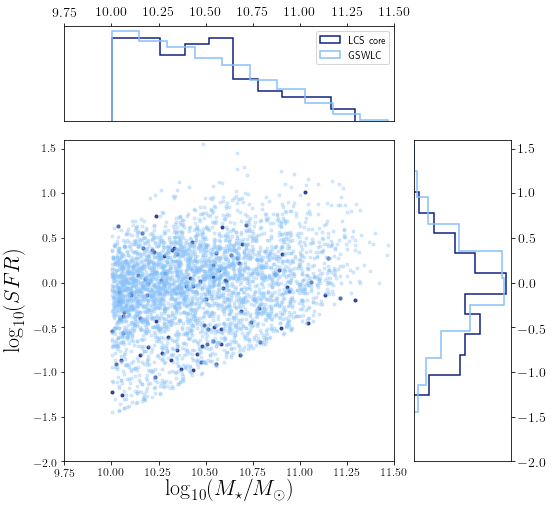

In [6]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
flag = ~b.lcs.cat['membflag'] & (b.lcs.cat['DELTA_V'] < 3.)
outfile1 = homedir+'/research/LCS/plots/lcsinfall-gsw-sfms.pdf'
outfile2 = homedir+'/research/LCS/plots/lcsinfall-gsw-sfms.png'
b.plot_sfr_mstar(lcsflag=flag,outfile1=outfile1,outfile2=outfile2)


# sSFR vs Mstar #



normalizing by radius of disk
number in core sample =  92
number in external sample =  3599
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.12
p-vale = 0.13875 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.29
p-vale = 0.00000 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

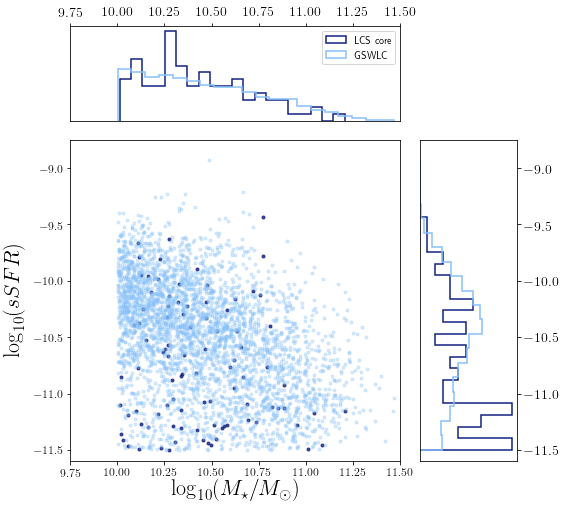

In [58]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
flag = b.lcs.cat['membflag'] 
outfile1 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar.png'
b.plot_ssfr_mstar(lcsflag=flag,outfile1=outfile1,outfile2=outfile2)

normalizing by radius of disk
number in core sample =  66
number in external sample =  3359
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.13
p-vale = 0.18973 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   0.42
p-vale = 0.22514 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.11
p-vale = 0.36597 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.92
p-vale = 0.92727 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

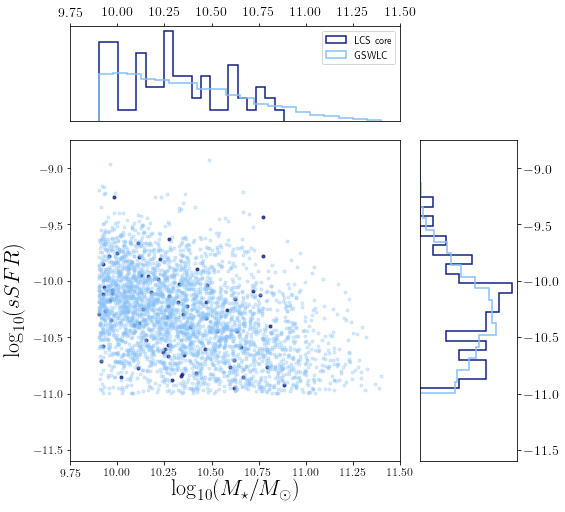

In [129]:
# using sSFR > -11, logMstar > 9.9
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
flag = b.lcs.cat['membflag'] 
outfile1 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar.png'
b.plot_ssfr_mstar(lcsflag=flag,outfile1=outfile1,outfile2=outfile2)

normalizing by radius of disk
number in core sample =  88
number in external sample =  3599
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.11
p-vale = 0.26468 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.20
p-vale = 0.00209 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

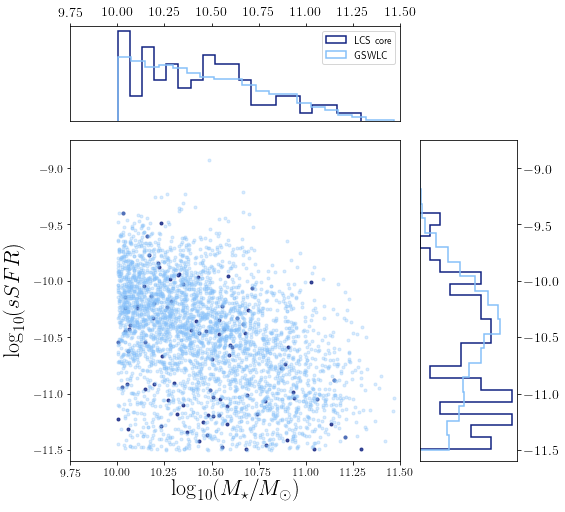

In [8]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
flag = ~b.lcs.cat['membflag'] & (b.lcs.cat['DELTA_V'] < 3.)
outfile1 = homedir+'/research/LCS/plots/lcsinfall-gsw-ssfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcsinfall-gsw-ssfrmstar.png'
b.plot_ssfr_mstar(lcsflag=flag,outfile1=outfile1,outfile2=outfile2)

### Splitting LCS by Cluster/group vs GSWLC Field ##

**CONCLUSIONS:**

Group members have lower SFRs compared to GSWLC sample.

In [80]:
sigma_split = 600
group = lcsgsw['CLUSTER_SIGMA'] < sigma_split
cluster = lcsgsw['CLUSTER_SIGMA'] > sigma_split

In [59]:
flag1 = lcsgsw['membflag'] &   (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut) & group
flag2 = (gsw['logMstar'] > masscut) & (gswssfr > ssfrcut)  & field_gsw
print('number in core sample = ',sum(flag1))
print('number in external sample = ',sum(flag2))
colormass(mstar[flag1],sfr[flag1],gsw['logMstar'][flag2],gsw['logSFR'][flag2],'LCS core groups','GSWLC','sfr-mstar-gswlc-field.pdf',ymin=-2,ymax=1.6,xmin=9.5,xmax=11.5,nhistbin=15,ylabel='$\log_{10}(SFR)$',contourflag=False,alphagray=.8)
plt.savefig(homedir+'/research/LCS/plots/lcsgroup-gsw-sfms.pdf')
plt.savefig(homedir+'/research/LCS/plots/lcsgroup-gsw-sfms.png')

TypeError: 'type' object is not subscriptable

number in core sample =  105
number in external sample =  1159
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.12
p-vale = 0.10553 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.32
p-vale = 0.00000 (prob that samples are from same distribution)


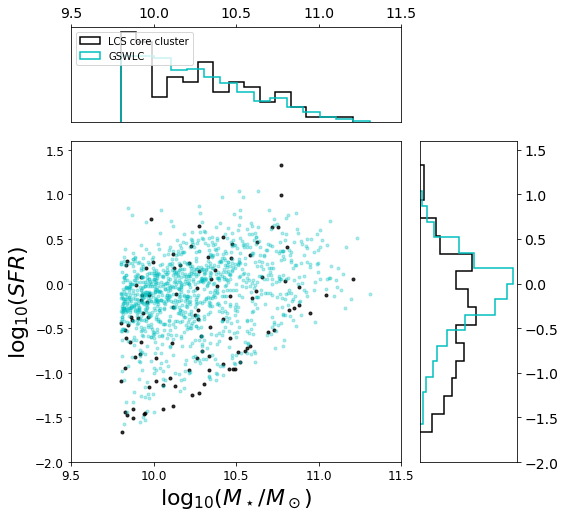

In [82]:
flag1 = lcsgsw['membflag'] &  (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut) & cluster
flag2 = (gsw['logMstar'] > masscut) & (gswssfr > ssfrcut)  & field_gsw
print('number in core sample = ',sum(flag1))
print('number in external sample = ',sum(flag2))
colormass(mstar[flag1],sfr[flag1],gsw['logMstar'][flag2],gsw['logSFR'][flag2],'LCS core cluster','GSWLC','sfr-mstar-gswlc-field.pdf',ymin=-2,ymax=1.6,xmin=9.5,xmax=11.5,nhistbin=15,ylabel='$\log_{10}(SFR)$',contourflag=False,alphagray=.8)
plt.savefig(homedir+'/research/LCS/plots/lcscluster-gsw-sfms.pdf')
plt.savefig(homedir+'/research/LCS/plots/lcscluster-gsw-sfms.png')

### Comparing sSFRs of LCS vs GSWLC ###

number in core sample =  137
number in external sample =  1159
KS Test:
D =   0.33
p-vale = 0.00000 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  39.14
p-vale = 0.04896 (prob that samples are from same distribution)


Text(0, 0.5, '$Normalized \\ Frequency$')

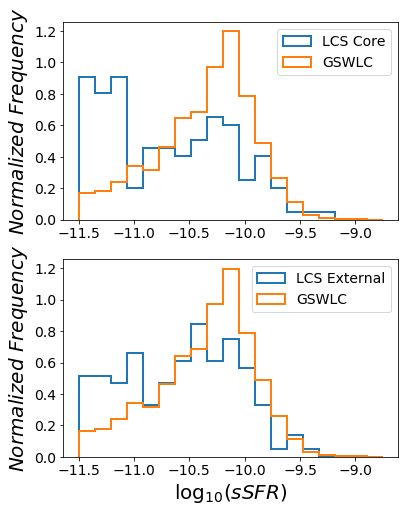

In [99]:
flag1 = lcsgsw['membflag'] &  (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut)
flag2 = (gsw['logMstar'] > masscut) & (gswssfr > ssfrcut)  & field_gsw
flag3 = ~lcsgsw['membflag'] &  (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut)
print('number in core sample = ',sum(flag1))
print('number in external sample = ',sum(flag2))
ks(ssfr[flag1],gswssfr[flag2])
plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
mybins = np.linspace(-11.5,-8.75,20)
t = plt.hist(ssfr[flag1],bins=mybins,histtype='step',normed=True,lw=2,label='LCS Core')
t = plt.hist(gswssfr[flag2],bins=mybins,histtype='step',normed=True,lw=2,label='GSWLC')
#t = plt.hist(ssfr[flag3],bins=mybins,histtype='step',normed=True,lw=2,label='LCS External')
plt.legend()
#plt.xlabel('$\log_{10}(sSFR)$',fontsize=20)
plt.ylabel('$Normalized \ Frequency$',fontsize=20)
plt.subplot(2,1,2)
mybins = np.linspace(-11.5,-8.75,20)
#t = plt.hist(ssfr[flag1],bins=mybins,histtype='step',normed=True,lw=2,label='LCS Core')
t = plt.hist(ssfr[flag3],bins=mybins,histtype='step',normed=True,lw=2,label='LCS External')
t = plt.hist(gswssfr[flag2],bins=mybins,histtype='step',normed=True,lw=2,label='GSWLC')
plt.legend()
plt.xlabel('$\log_{10}(sSFR)$',fontsize=20)
plt.ylabel('$Normalized \ Frequency$',fontsize=20)

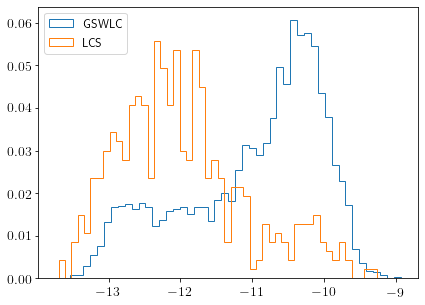

In [127]:
plt.figure()
nbins = 50
flag = (g.cat['logSFR'] > -99) & (g.cat['logMstar'] > 9.9) & (g.ssfr < -4)
#t = plt.hist(g.ssfr[flag],bins=nbins,normed=True,histtype='step',label='GSWLC')
t = plt.hist(g.ssfr[flag],bins=nbins,weights=np.ones(sum(flag))/sum(flag),histtype='step',label='GSWLC')
flag = (lcs.cat['logSFR'] > -99) & (lcs.cat['logMstar'] > 9.9) & (lcs.ssfr < -4) &  lcs.cat['membflag']
#t = plt.hist(lcs.ssfr[flag],bins=nbins,normed=True,histtype='step',label='LCS')
t = plt.hist(lcs.ssfr[flag],bins=nbins,weights=np.ones(sum(flag))/sum(flag),histtype='step',label='LCS')
plt.legend(loc='upper left')

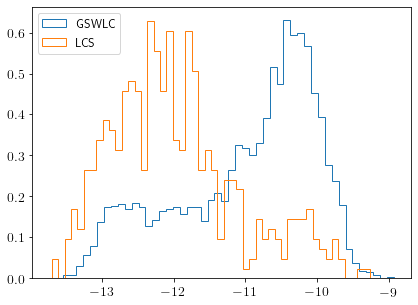

In [128]:
plt.figure()
nbins = 50
flag = (g.cat['logSFR'] > -99) & (g.cat['logMstar'] > 9.9) & (g.ssfr < -4)
t = plt.hist(g.ssfr[flag],bins=nbins,normed=True,histtype='step',label='GSWLC')
#t = plt.hist(g.ssfr[flag],bins=nbins,weights=np.ones(sum(flag))/sum(flag),histtype='step',label='GSWLC')
flag = (lcs.cat['logSFR'] > -99) & (lcs.cat['logMstar'] > 9.9) & (lcs.ssfr < -4) &  lcs.cat['membflag']
t = plt.hist(lcs.ssfr[flag],bins=nbins,normed=True,histtype='step',label='LCS')
#t = plt.hist(lcs.ssfr[flag],bins=nbins,weights=np.ones(sum(flag))/sum(flag),histtype='step',label='LCS')
plt.legend(loc='upper left')

# Still to do #
- bootstrap our external sample, selecting galaxies that have some distribution in SFR-Mass plane as the z0MGS sample.
- this will let us include size in the SF MS plot, using bootstrapped external sample
- incorporate SF in the disk shrinking model.  apply to SF-stellar mass plane. where do objects go in main sequence.  do we reproduce low SF tail seen in core sample.
- what if we split LCS into low and high mass clusters

# Results #

- pop of galaxies with low sSFRs in clusters
- we show that SF is suppressed in infall regions because the external sample is similar in SF-M* to core sample.
- drop in SFRs can be explained by disk shrinking?




# Matching GSWLC-2 and Group Catalogs #

- matched GSWLC-X2 and Tempel+2012 GALAXY group catalog using topcat
  - matching by SDSS objid yielded only a few thousand matches, so I concluded that GSWLC is using DR7 ids whereas tempel is using DR8.  Should look into this more closely b/c (1) why would salim use DR7 in a 2018 paper?  (2) salim does not specifically mention which DR the ids correspond to.
  - matched by RA, DEC, 1 arcsec offset
    - best match, symmetric
    - join 1 and 2
    - 514,186 matches
    - saved as fits-basic:  ~/research/GSWLC/GSWLC-X2-Tempel2012-groups.fits
    
    
    

In [105]:
# read in matched catalog that has GSWLC and Tempel group galaxies
gg = Table(fits.getdata('/home/rfinn/research/GSWLC/GSWLC-X2-Tempel2012-groups.fits'))
gg = gg[gg['redshift'] < 0.04]

In [106]:
# catalog with group info
tgroups = Table(fits.getdata('/home/rfinn/research/sdss-tempel/dr8_ggc.fits',2))

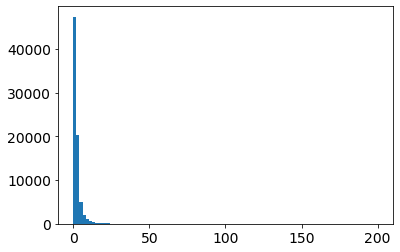

In [109]:
plt.figure()
mybins = np.linspace(0,200,100)
t = plt.hist(tgroups['nrich'],bins=mybins)

In [110]:
gg

<Table length=514186>
  id    idcl  nrich redshift ... flag_midir flag_mgs      Separation     
int32  int32  int16 float32  ...   int16     int16         float64       
------ ------ ----- -------- ... ---------- -------- --------------------
    16      1     2 0.104439 ...          6        1  0.04506360017438818
    17      1     2 0.106202 ...          7        1  0.02900791424883003
    18      2     3 0.132497 ...          0        1 0.049092403110811415
    19      2     3 0.133721 ...          0        1   0.0445205440503209
    22      2     3 0.133109 ...          6        1  0.07048647425396412
    21      3     2 0.139811 ...          6        1  0.07255010812356293
 97487      3     2  0.13896 ...          2        1  0.04683095094840111
    23      4     2 0.063235 ...          7        1  0.06436688629151503
    25      4     2 0.063067 ...          2        1  0.01460158902986252
    27      5     4 0.107642 ...          0        1  0.10867884228156727
   ...    ...   ...      ... ...        ...      ...                  ...
576468 388757     1 0.147332 ...          1        1  0.06838679035531006
576472 388761     1 0.113021 ...          2        1  0.07109624609791332
576476 388763     1 0.108786 ...          2        1   0.2712455127771415
576477 388764     1 0.116256 ...          6        1  0.02123155503986127
576480 388766     1 0.146856 ...          7        1  0.12014956999153588
576483 388767     1 0.137989 ...          6        1  0.05078285187298792
576484 388768     1 0.113693 ...          1        1 0.027170684989730475
576486 388769     1 0.154885 ...          7        1  0.08841777291812682
576487 388770     1 0.143519 ...          6        1  0.08870170569276291
576489 388771     1 0.148589 ...          7        1  0.08504954109834578

# Next steps #

- what do galaxies with -11 < ssfr < -11.5 look like.  We could pull up NSA cutouts for LCS galaxies in this range
- what is the morphologies of the SF galaxies.  Use galaxy zoo information included in Tempel+ catalog
- try a Sf cut that is parallel to the main sequence.  factor of 5 below?
- fit offset between salim+07 mass-dependent main sequence and the MS for the GSWLC.  There is about 0.3 dex offset

- how to incorporate SFR into simple modeling of cluster infall
  - from first paper we have best-fit infall time
  - assume exponential disk for SF
  - decrease external sample by the amount lost by disk shrinking
  - compare resulting population to LCS core SFRs

# What does shrinking size imply about SFR #

$$ I (r) = I_0 exp(-r/Re) $$

$$ SFR \propto \int_0^{R_{max}} I(r) dr $$

Find average size of external sample, average size of core sample, what is offset in SFRs?

In [19]:
%run ~/github/LCS/python/Python3/LCSbase.py

nothing happening here
(1800, 1800)
updating table


<Figure size 489.6x360 with 0 Axes>

In [35]:
sizecore = np.median(g.sizeratio[g.membflag & g.sampleflag])

In [36]:
sizeexternal = np.median(g.sizeratio[~g.membflag & g.sampleflag])

In [30]:
SFRexternal = 1 - np.exp(-1*np.median(g.sizeratio[~g.membflag & g.sampleflag]))
SFRcore = 1 - np.exp(-1*np.median(g.sizeratio[g.membflag & g.sampleflag]))

In [31]:
# Drop in SFR
drop = 1 - SFRcore/SFRexternal

In [39]:
ratioSize = sizecore/sizeexternal
ratioSFR = SFRcore/SFRexternal
print("drop in size = {:.2f}, drop in SFR ={:.2f}".format(1-ratioSize,1-ratioSFR))

drop in size = 0.26, drop in SFR =0.18


normalizing by radius of disk
CORE VS EXTERNAL
KS Test:
D =   0.19
p-vale = 0.04910 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

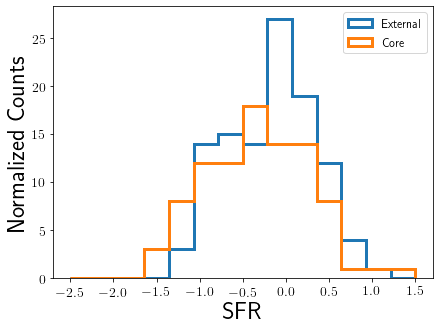

In [57]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
lcs.compare_sfrs(nbins=15)

# IDs of low sSFR Galaxies #

In [62]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py

b.print_lowssfr_nsaids()

normalizing by radius of disk
70595
70694
43814
43840
43874
68305
82122
82189
99837
99838
99840
166676
166701
72635
72688
72745
72759
72773
72779
146115
79534
166036
166081
89063
89097
103607
103628
103795
103841
103935
104179
104231
104244
142735
142776
142790
142797
162770
162832
162925


normalizing by radius of disk


<Figure size 489.6x360 with 0 Axes>

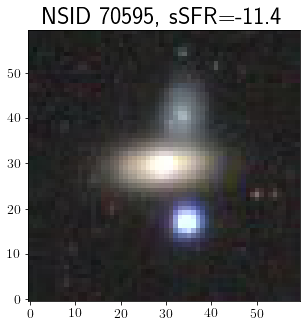

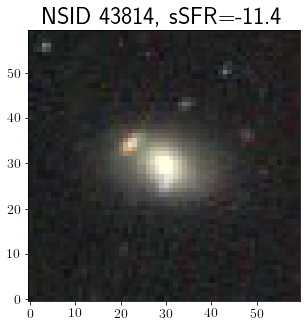

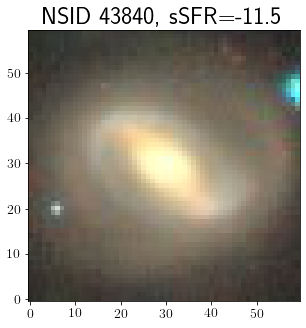

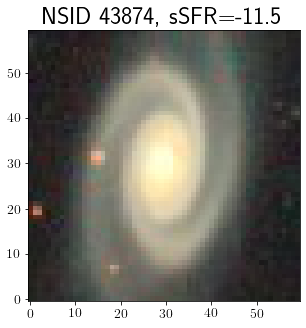

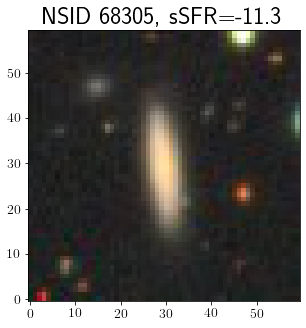

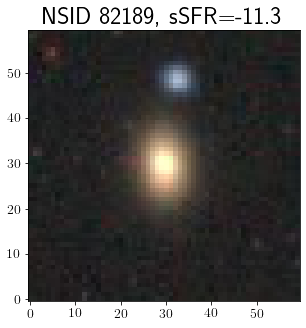

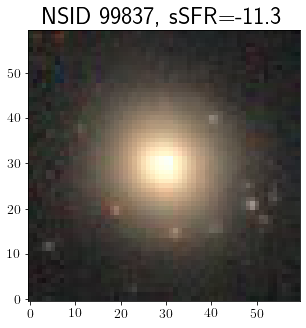

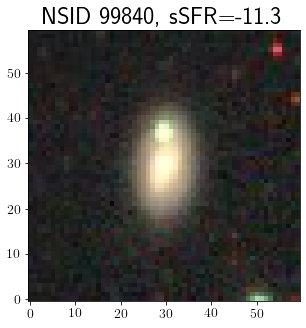

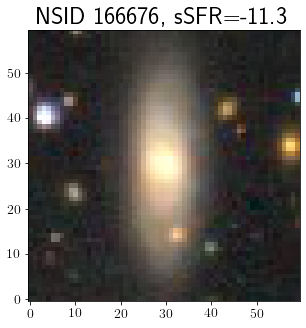

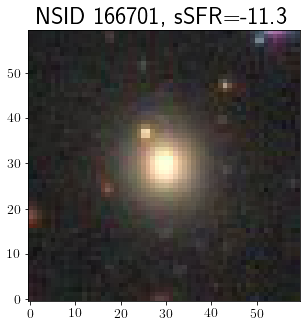

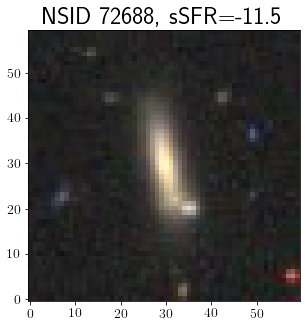

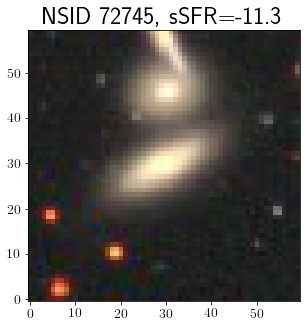

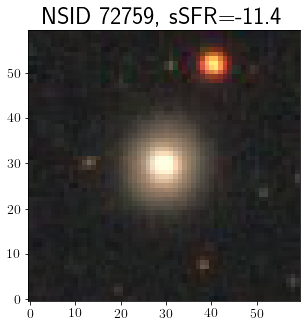

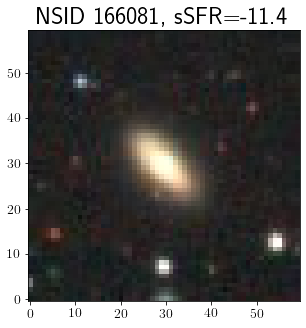

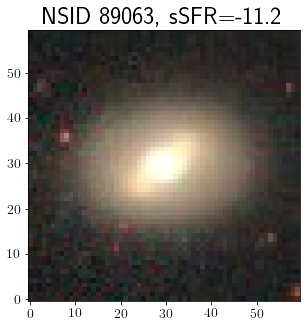

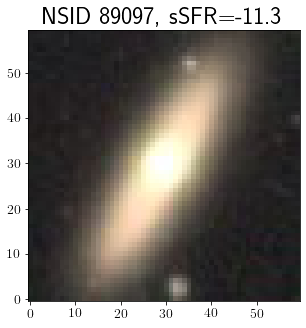

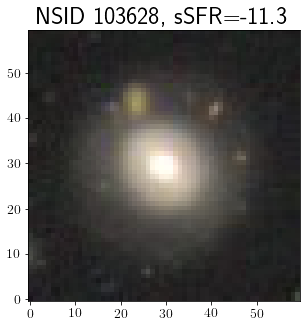

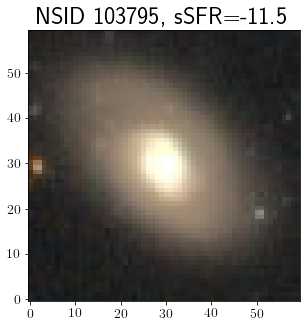

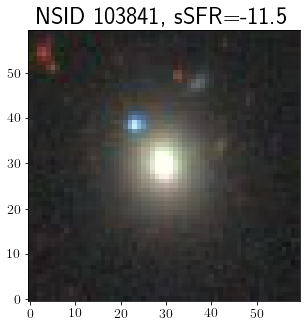

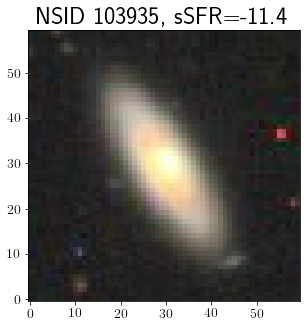

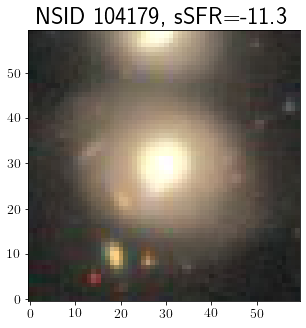

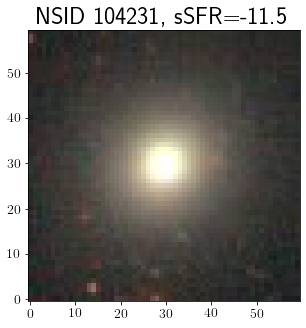

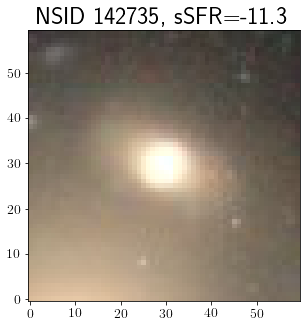

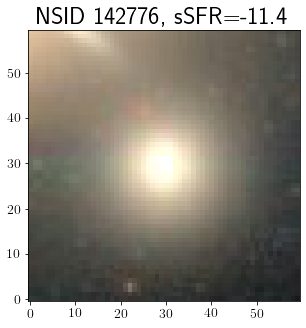

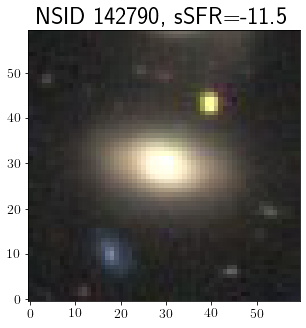

In [94]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
b.get_legacy_images(ssfrmax=-11.2,ssfrmin=-11.5)

normalizing by radius of disk


<Figure size 489.6x360 with 0 Axes>

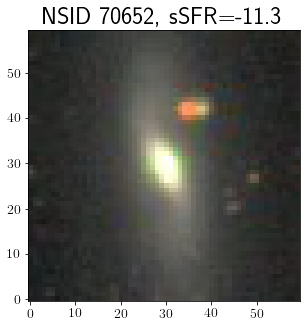

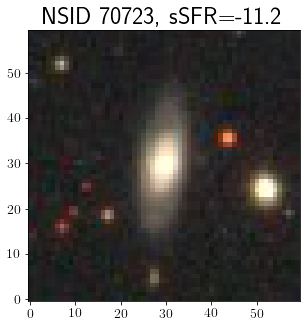

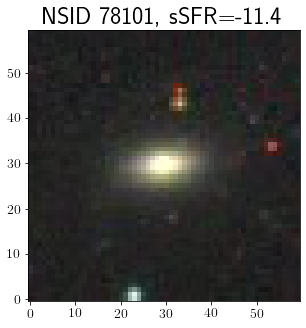

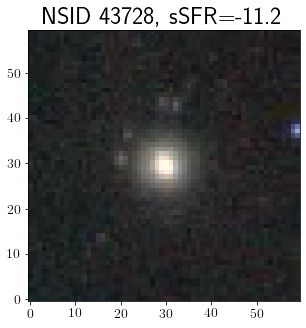

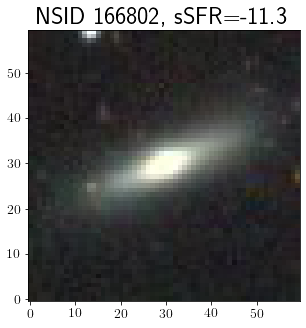

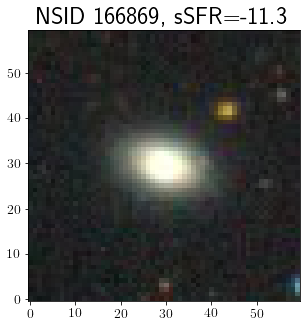

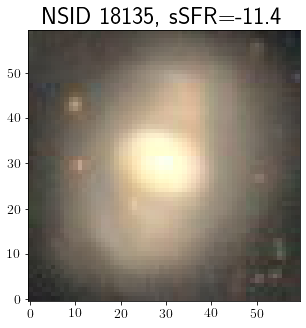

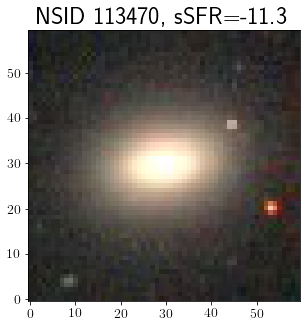

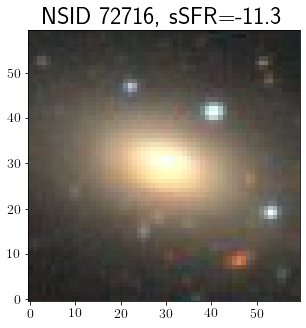

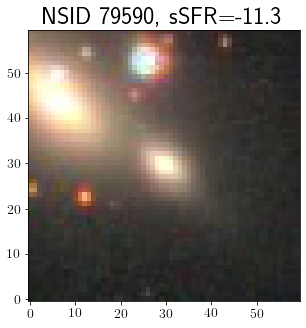

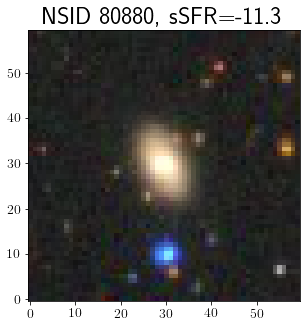

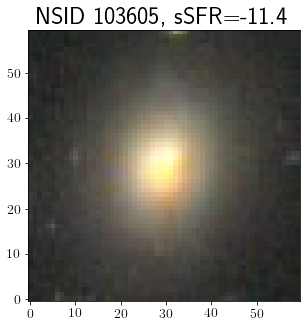

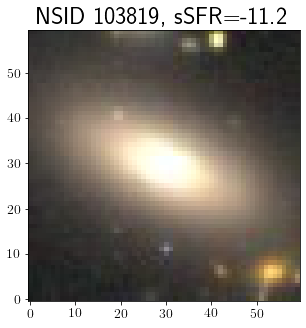

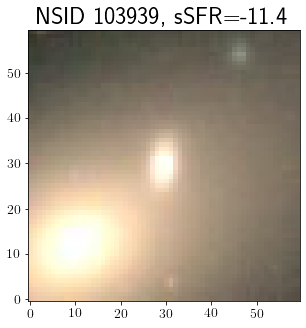

In [91]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
b.get_legacy_images(lcsflag = ~b.lcs.cat['membflag'],ssfrmax=-11.2,ssfrmin=-11.4)

# Use disk galaxies only #
We are detecting an excess of low sSFR galaxies in LCS core and external samples.  Even when we cut by group/cluster mass - we find excess in every combination of LCS sample.

Concern: is sSFR = -11.5 picking up tail of the passive sequence (meaning these are not SF, but we are detecting dust emission from post main sequence stars).  If this is the case, then the trends with environment that we are detecting are just due to the morphology-density relation.

For example, 

in clusters:
- 10 low sSFR spiral - truly low sSFR
- mixing in 20 E/S0 galaxies in the cluster - not low sSFR

in field:
- 10 low sSFR
- 5 E/S0

If we can remove E/S0 from both the field and cluster samples, then we can be more confident that we are detecting low sSFR galaxies.

On the other hand, there can by E/S0 galaxies with some residual SF.  Need to think about how this affects results, or do it both ways: with and without a morphology cut.

# Implementation #

Two approaches: NSA Sersic index or galaxy zoo morphology from Tempel catalogs

- we could cut on NSA sersic index
  - need 
- would need to match tempel field to GSWLC and NSA (LCS galaxies already have info from all of these catalogs)


## Tempel + galaxy zoo ##
- or use tempel - that includes prob of spiral
- BV matched LCS+GSWLC sample to tempel galaxies file
  - best match, 10 arcsec
  - all but 10 galaxies are matched
- make a cut on early type
  - (pE + pS0) > 0.5 = early type galaxy
- keep only late-type galaxies for both
- repeat SFR-M* comparison


## Field Sample ##
- Benedetta will resend the GSWLC M < 12.5 catalog.  not sure if the single galaxies are included.  
- send full catalog, and I will cut in redshift range

- using updated catalogs now.  the results are unchanged

In [11]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py

normalizing by radius of disk


# sSFR-Mstar: Compare LCS and GSWLC - no B/T cut #
# (updates from 7/1/2020) #

- limited by stellar mass, ssfr, and B/T < 0.3


### LCS core vs GSWLC Field, no BT cut ###

* sSFRs are different
* stellar masses are the same

number in core sample =  92
number in external sample =  7835
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.11
p-vale = 1.751e-01 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.25
p-vale = 2.437e-05 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

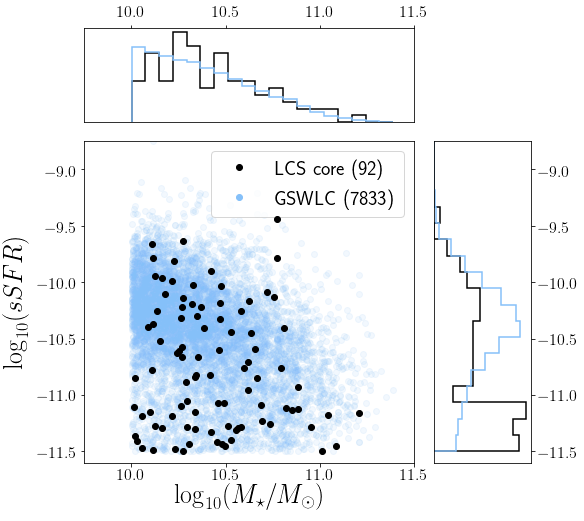

In [159]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py 
flag = b.lcs.cat['membflag'] 
outfile1 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar.png'
b.plot_ssfr_mstar(lcsflag=flag,outfile1=outfile1,outfile2=outfile2)

### LCS infall vs GSWLC Field, no BT cut ###

* sSFRs are different
* stellar masses are the same

number in core sample =  88
number in external sample =  7835
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.07
p-vale = 6.939e-01 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.22
p-vale = 2.472e-04 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

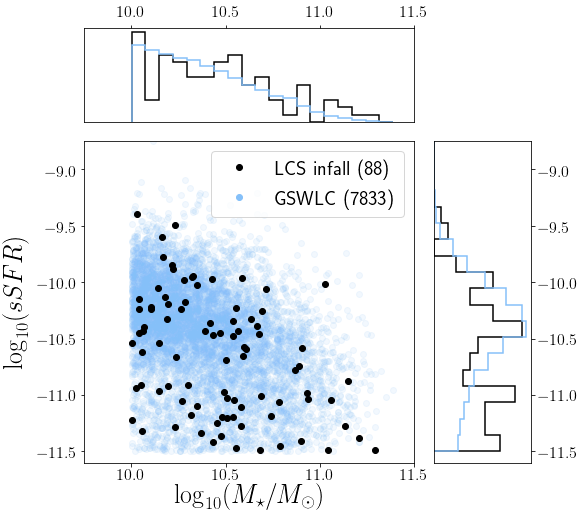

In [160]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py 
flag = ~b.lcs.cat['membflag'] & (b.lcs.cat['DELTA_V'] < 3.)
outfile1 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar.png'
b.plot_ssfr_mstar(lcsflag=flag,label='LCS infall',outfile1=outfile1,outfile2=outfile2)

### LCS Core vs infall, no BT cut ###

* sSFRs are not significantly different
* stellar masses are the same

number in core sample =  92
number in external sample =  88
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.16
p-vale = 1.635e-01 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.14
p-vale = 2.710e-01 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

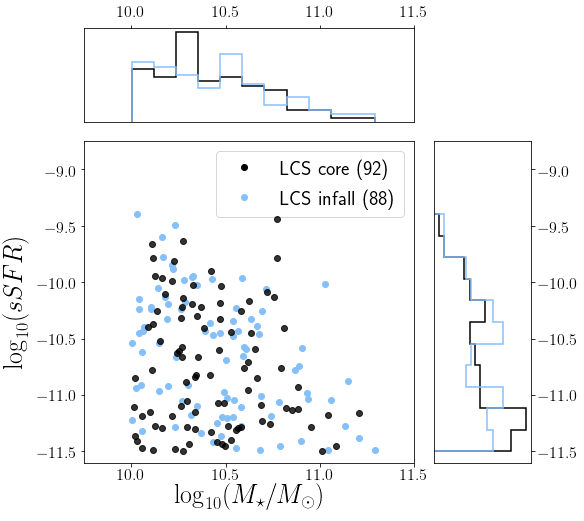

In [161]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py 
outfile1 = homedir+'/research/LCS/plots/lcscore-external-ssfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-external-ssfrmstar.png'
b.plot_ssfr_mstar_lcs(outfile1=outfile1,outfile2=outfile2,nbins=12)

# With B/T Cut #

### core vs GSWLC ###

* sSFRs are different
* mstar is the same

number in core sample =  38
number in external sample =  4791
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.13
p-vale = 4.996e-01 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.35
p-vale = 1.630e-04 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

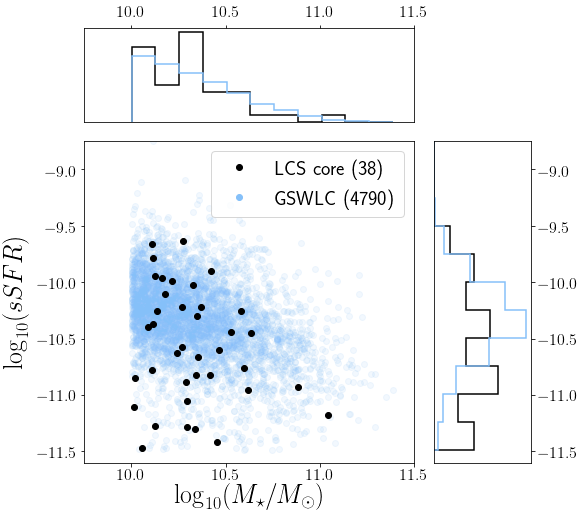

In [162]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py --cutBT
flag = b.lcs.cat['membflag'] 
outfile1 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar-BTcut.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-gsw-ssfrmstar-BTcut.png'
b.plot_ssfr_mstar(lcsflag=flag,outfile1=outfile1,outfile2=outfile2,nbins=12)

### infall vs GSWLC with B/T cut ###

* sSFRs are indistinguishable
* stellar masses are slightly different same


**do we need to make a mass-matched sample?**

number in core sample =  39
number in external sample =  4791
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.22
p-vale = 3.346e-02 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.11
p-vale = 6.539e-01 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

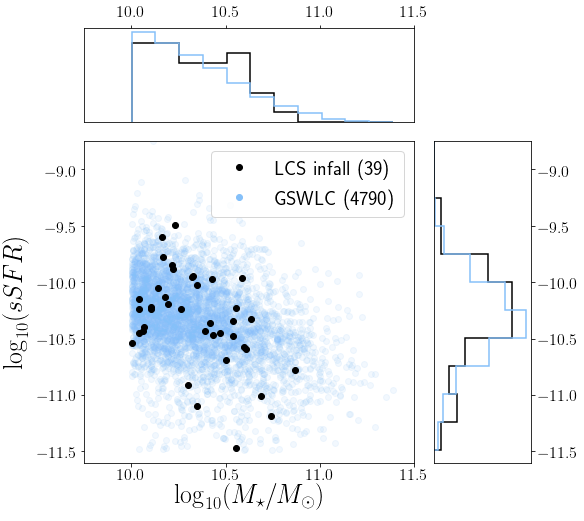

In [163]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py --cutBT
flag = ~b.lcs.cat['membflag'] & (b.lcs.cat['DELTA_V'] < 3.)
outfile1 = homedir+'/research/LCS/plots/lcsinfall-gsw-ssfrmstar-BTcut.pdf'
outfile2 = homedir+'/research/LCS/plots/lcsinfall-gsw-ssfrmstar-BTcut.png'
b.plot_ssfr_mstar(lcsflag=flag,label='LCS infall',outfile1=outfile1,outfile2=outfile2,nbins=12)

### LCS core vs infall with B/T cut###

* sSFRs are not different
* stellar masses are slightly different

number in core sample =  38
number in external sample =  39
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.32
p-vale = 3.182e-02 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.19
p-vale = 4.185e-01 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

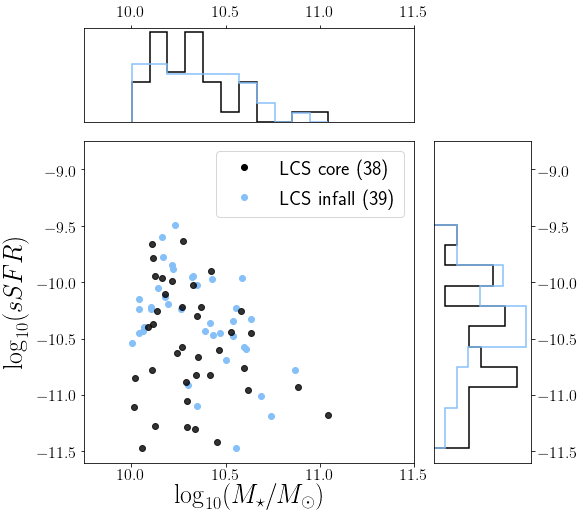

In [164]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py --cutBT
outfile1 = homedir+'/research/LCS/plots/lcscore-external-ssfrmstar-BTcut.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-external-ssfrmstar-BTcut.png'
b.plot_ssfr_mstar_lcs(outfile1=outfile1,outfile2=outfile2,nbins=12)

# SFR - Mstar: no B/T cut #

repeating above three plots, but for SFR vs Mstar

### LCS core vs GSWLC field, no BT cut ###

* SFRs are VERY different
* stellar masses are different

**need to make a mass-matched sample?**
as a counter point, the difference in stellar mass distributions are due to the 
GSWLC sample having lower mass galaxies. This would increase the fraction of low-SFR galaxies in the GSWLC sample, yet the LCS core galaxies have even lower SFRs. 

number in core sample =  92
number in external sample =  7835
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.19
p-vale = 2.013e-03 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.31
p-vale = 4.216e-08 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

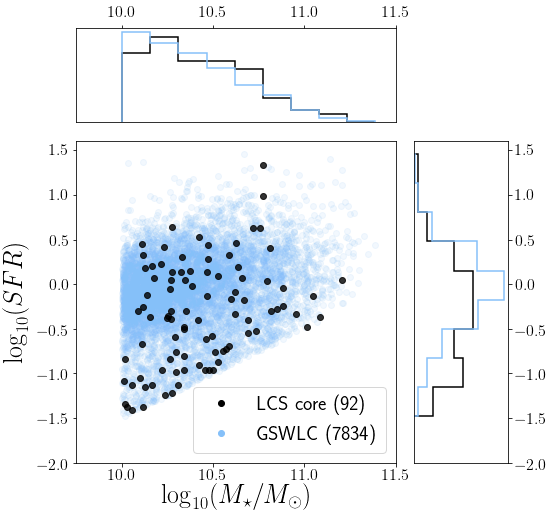

In [58]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py 
flag = b.lcs.cat['membflag'] 
outfile1 = homedir+'/research/LCS/plots/lcscore-gsw-sfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-gsw-sfrmstar.png'
b.plot_sfr_mstar(lcsflag=flag,outfile1=outfile1,outfile2=outfile2)

### SFR-M*: LCS infall vs GSWLC, no BT cut ###

* stellar masses are very diff (more low-mass galaxies in gswlc)
* SFRs are not different

**again, need mass-matched sample**

number in core sample =  88
number in external sample =  7835
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.22
p-vale = 4.733e-04 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.10
p-vale = 3.723e-01 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

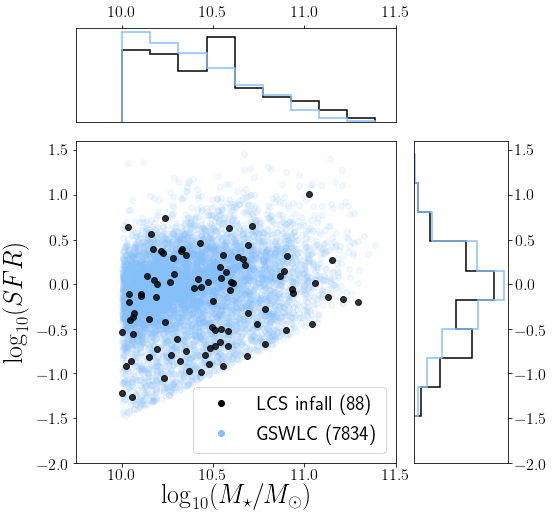

In [165]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py 
flag = ~b.lcs.cat['membflag'] & (b.lcs.cat['DELTA_V'] < 3.)
outfile1 = homedir+'/research/LCS/plots/lcsinfall-gsw-sfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcsinfall-gsw-sfrmstar.png'
b.plot_sfr_mstar(lcsflag=flag,label='LCS infall',outfile1=outfile1,outfile2=outfile2)

### SFR-M*: LCS core vs infall, no BT cut ###

* stellar masses are not diff 
* SFRs are not different

**again, need mass-matched sample**

number in core sample =  92
number in external sample =  88
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.11
p-vale = 5.559e-01 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.13
p-vale = 4.026e-01 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

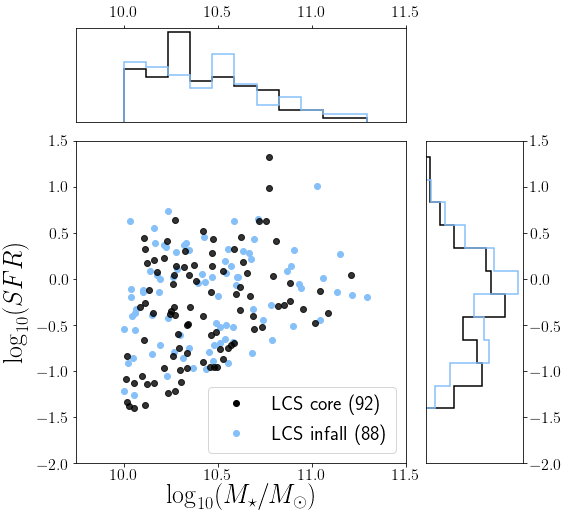

In [60]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
outfile1 = homedir+'/research/LCS/plots/lcscore-external-sfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-external-sfrmstar.png'
b.plot_sfr_mstar_lcs(outfile1=outfile1,outfile2=outfile2,nbins=12)

# SFR- Mstar with B/T < 0.3 #

### SFR-M*: LCS infall vs GSWLC, with BT cut ###


* SFRs are not different
* stellar masses are very diff (more low-mass galaxies in gswlc)

**again, need mass-matched sample**

number in core sample =  38
number in external sample =  4791
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.20
p-vale = 9.283e-02 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.25
p-vale = 1.518e-02 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

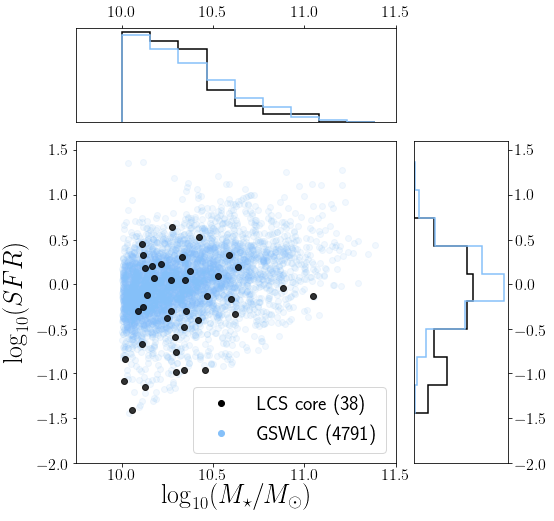

In [61]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py --cutBT
flag = b.lcs.cat['membflag'] 
outfile1 = homedir+'/research/LCS/plots/lcscore-gsw-sfrmstar-BTcut.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-gsw-sfrmstar-BTcut.png'
b.plot_sfr_mstar(lcsflag=flag,outfile1=outfile1,outfile2=outfile2)

### SFR-M* :  LCS infall vs GSWLC - with BT cut ###

* SFRs are marginally different
* stellar masses are indistinguisable


number in core sample =  39
number in external sample =  4791
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.14
p-vale = 4.371e-01 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.24
p-vale = 2.155e-02 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

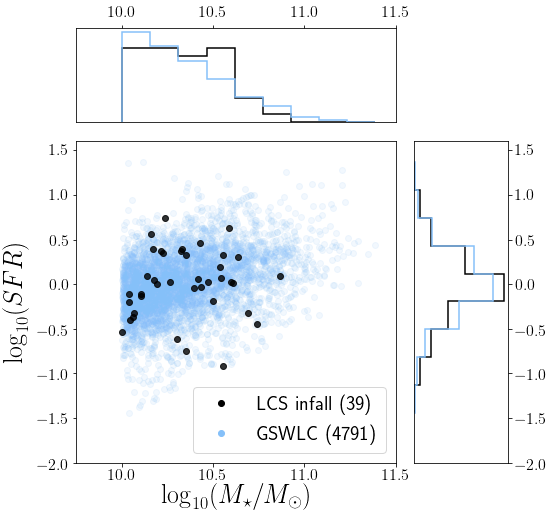

In [62]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py --cutBT
flag = ~b.lcs.cat['membflag'] & (b.lcs.cat['DELTA_V'] < 3.)
outfile1 = homedir+'/research/LCS/plots/lcsinfall-gsw-sfrmstar-BTcut.pdf'
outfile2 = homedir+'/research/LCS/plots/lcsinfall-gsw-sfrmstar-BTcut.png'
b.plot_sfr_mstar(lcsflag=flag,label='LCS infall',outfile1=outfile1,outfile2=outfile2)

### SFR - M*: LCS core vs infall, with B/T cut ###

* masses and SFRs are the same

number in core sample =  38
number in external sample =  39
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.15
p-vale = 6.981e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.57
p-vale = 0.63517 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.27
p-vale = 9.633e-02 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   2.08
p-vale = 0.04450 (prob that samples are from same distribution)


<Figure size 489.6x360 with 0 Axes>

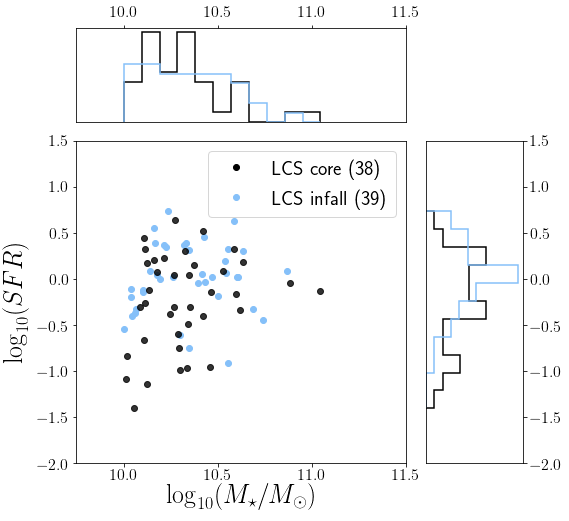

In [6]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py --cutBT
outfile1 = homedir+'/research/LCS/plots/lcscore-external-sfrmstar-BTcut.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-external-sfrmstar-BTcut.png'
b.plot_sfr_mstar_lcs(outfile1=outfile1,outfile2=outfile2,nbins=12)

# Compare B/T distribution of core and infall galaxies #

* need to see if BT distribution is similar
* if not, we will need to cut on BT for the simulation
* otherwise we will conflate multiple factors


CONCLUSION
* B/T of core/infall are significantly different. pvalue = 1.6e-10 
* after cutting B/T < 0.3, the difference is much smaller.  pvalue = 0.015

Ks_2sampResult(statistic=0.18716414862340822, pvalue=1.626687673450533e-10)
Ks_2sampResult(statistic=0.12097346123698256, pvalue=0.015355063312994743)


<Figure size 489.6x360 with 0 Axes>

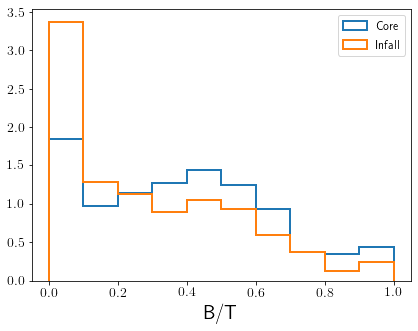

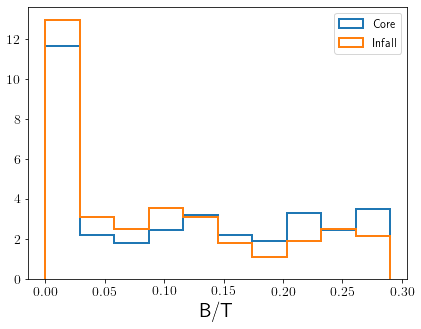

In [57]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py 
outfile1 = homedir+'/research/LCS/plots/lcscore-external-BTcut.pdf'
outfile2 = homedir+'/research/LCS/plots/lcscore-external-BTcut.png'
b.lcs_compare_BT()#outfile1=outfile1,outfile2=outfile2,nbins=12)
plt.savefig(outfile1)
plt.savefig(outfile2)

With B/T < 0.3 cut

Quick comparison of LCS core and infall.

We are able to detect a difference in sSFRs between core and infall, but the significance is not super high (pvalue = 0.014).

We are therefore getting a consistent story:

- difference in sSFRs between core and infall of LCS sample, but significance is not high
- we create a comparison sample from GSWLC
  - cut in redshift to match LCS
  - match to Tempel, limit to galaxies in halos with $logM < 12.5$ (we now include isolated galaxies)
  - match to Simard+2011, limit to galaxies with $B/T < 0.3$
- LCS core has significantly lower sSFR than GSWLC field ($>5\sigma$)
- LCS infall also has lower sSFR than GSWLC field ($>5\sigma$)

Where to next:

- need to find meaningful way to link the size and sSFR evolution
  - are the changes in size and sSFR consistent?
  - can we get better handle on quenching timescale by including comparison of sSFR with GSWLC field?
  - how do these results revise the delay+rapid quenching model?

Long term:

- need size measurements for a large field sample!
- repeat for large sample of groups and clusters - can we measure a halo mass where this becomes important?
  - could also use tempel catalogs, and repeat for
    - logM < 12.5
    - 12.5 < logM < 13.0
    - 13.0 < logM < 13.5
    - 13.5 < logM < 14.0
    
Concerns:

- is B/T distribution different (even for B/T < 0.3 galaxies) between LCS and GSWLC field?

# NOTES: #

- can we predict the size of the disks in the field?
  - we solve for dr/dt
  - we have infall - an estimate of how the infall region has been "not field"
  - Bendo+2007 paper, has size measurements, ratios R24/R > 1
  
- can we refine the model. fitting disk times, we can also now incorporate SFRs.

- infall models tell you time b/w field/infall and field/core

- quantify - how much lower are cluster SFRs?

- what happens to R24 if disk is truncated?

### Update Original model - Shrink disk ###

- We started with size distribution in infall region.  
- Get get a processing time from infall models.  (used a range between 0 and 4Gyr)
- Then we solve for best-fitting dr/dt - where we compare distribution of shrunk infall sizes with distribution of core sizes using a KS test.

- for every galaxy that we are shrinking in size, we use comparison of original profile vs shrunk profile to calculate the change in SFR


$$ \Delta SFR = 1 - \int_0^\inf I(r, Re_{shrunk}, n)/\int I(r, Re_{original}, n) $$ 

$$ SFR_{core,predicted} = SFR_{infall} - \Delta SFR $$

$$ I(r) = Sersic profile $$

Compare the distribution of resulting SFRs to the distribution of SFRs in the core.

Need to compare SFR and size distributions.


** IMPLEMENTATION **

- Need 

### Model 2: Truncating  ###

** What if shrinking is due to Truncation rather than shrinking? **

- if we have a truncated sersic profile and refit with a sersic profile, what happens to the resulting Re?

- this will probably make different predictions about SFRs


### Third Model:  Shrink Re and Boost  ###

- maintain the flux

**Questions**

- What about controlling for stellar mass?

- SINGS sample - covers range of galaxies

- predict size distributions of field galaxies - motivates measuring the size of SF disk for a large sample of field galaxies
  - we are just going to use LCS sample for modeling because we need 
  - we need a bigger sample of field galaxies, could motivate a proposal (ADAP, NSF)

- how do we fold in the two KS tests (size and SFRs)? - 2D (size and SFR)
  - size and SFRs measurements are independent
  
# From 5/20/20

**Measuring "Goodness of Fit"**
- One approach is to use the best-fit shrinking time to predict distribution of SFs in the core
  - then compare core and predicted SFRs using a KS test to see if they are consistent and to rule out any infall times that produce SFRs that are inconsisten with SFR distribution of core sample.
  - downside: we are not really using both 
- let's take all the acceptable timescales and see if we can reject any of these based on their prediction for change in SFRs
- if we end up with a family of acceptable solutions, is there a way to tell which is the best solution in a statistically robust way

In paper, we used different infall times because we could have a large distribution of infall times.

We assigned infall times randomly, but we let tmax vary.
models say infall time should be less than 5 Gyr. 



normalizing by radius of disk
number in core sample =  38
number in external sample =  39
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.22
p-vale = 0.24495 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.35
p-vale = 0.01377 (prob that samples are from same distribution)


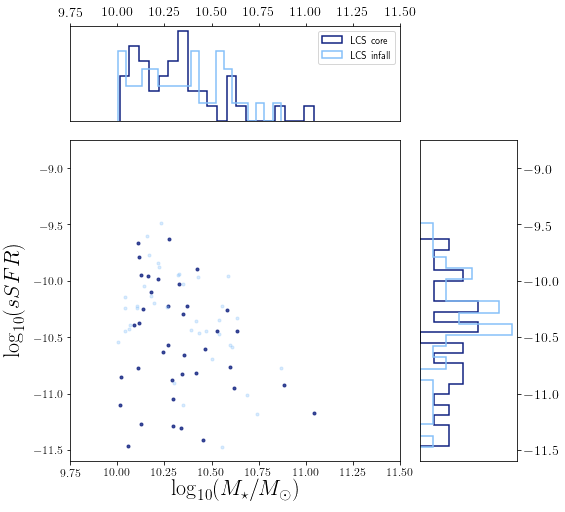

In [26]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/lcs_paper2.py
outfile1 = homedir+'/research/LCS/plots/lcs-core-infall-ssfrmstar.pdf'
outfile2 = homedir+'/research/LCS/plots/lcs-core-infall-ssfrmstar.png'
b.plot_ssfr_mstar_lcs(outfile1=outfile1,outfile2=outfile2)

# Simulation

- the table that is LCS matched to GSWLC is missing 26/225 galaxies with size measurements
- want to use the full sample for best comparability with model in paper1

- table is created by LCSbase.py - update_table()
- I updated the simulation program to read the main data table directly, rather than writing out a separate version for the simulation.

  

In [74]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSbase.py

/home/rfinn/github/LCS/python/Python3/LCSbase.py:74: RuntimeWarning: divide by zero encountered in true_divide
  self.MAG24 = 2.5*np.log10(3631./(self.s.FLUX24*1.e-6))
/home/rfinn/github/LCS/python/Python3/LCSbase.py:88: RuntimeWarning: invalid value encountered in true_divide
  self.AGNKAUFF= ((np.log10(self.s.O3FLUX/self.s.HBFLUX) > (.61/(np.log10(self.s.N2FLUX/self.s.HAFLUX)-.05)+1.3)) | (np.log10(self.s.N2FLUX/self.s.HAFLUX) > 0.)) #& (self.s.HAEW > 0.)
/home/rfinn/github/LCS/python/Python3/LCSbase.py:88: RuntimeWarning: invalid value encountered in log10
  self.AGNKAUFF= ((np.log10(self.s.O3FLUX/self.s.HBFLUX) > (.61/(np.log10(self.s.N2FLUX/self.s.HAFLUX)-.05)+1.3)) | (np.log10(self.s.N2FLUX/self.s.HAFLUX) > 0.)) #& (self.s.HAEW > 0.)
/home/rfinn/github/LCS/python/Python3/LCSbase.py:88: RuntimeWarning: invalid value encountered in greater
  self.AGNKAUFF= ((np.log10(self.s.O3FLUX/self.s.HBFLUX) > (.61/(np.log10(self.s.N2FLUX/self.s.HAFLUX)-.05)+1.3)) | (np.log10(self.s.N2FLUX/self

nothing happening here


/home/rfinn/github/LCS/python/Python3/LCSbase.py:270: RuntimeWarning: divide by zero encountered in log10
  self.logSFR_IR_KE = np.log10(self.nuLnu24_ZDIST.cgs.value)-42.69


(1800, 1800)


/home/rfinn/github/LCS/python/Python3/LCSbase.py:151: RuntimeWarning: divide by zero encountered in log10
  self.sb_obs[flag]=self.s.fcmag1[flag] + 2.5*np.log10(np.pi*((self.s.fcre1[flag]*mipspixelscale)**2)*self.s.fcaxisratio1[flag])
/home/rfinn/github/LCS/python/Python3/LCSbase.py:165: RuntimeWarning: invalid value encountered in greater
  self.HIflag = self.s.HIMASS > 0.


updating table


Simulation program will read 

'/home/rfinn/research/LCS/tables/LCS_all_size_KE_SFR.fits'

directly

In [34]:
tab  = Table.read('/home/rfinn/research/LCS/tables/LCS-simulation-data.fits')

In [49]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py

best dr/dt =  -0.2999999999999985
disk is quenched in 3.3 Gyr
fraction that are quenched = 0.12
KS p value = 9.99807214e-01


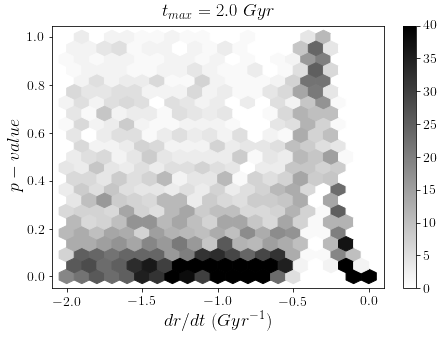

In [58]:
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=2,drdt_step=0.05,nrandom=100)

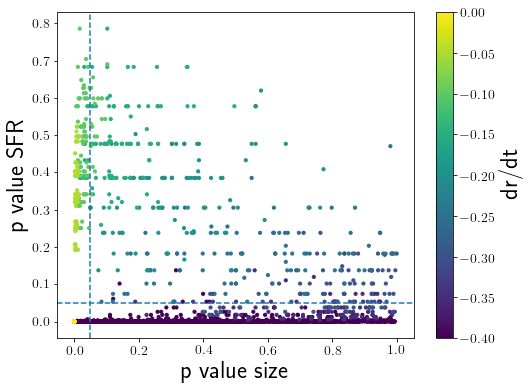

In [73]:
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=10,vmin=-.4,vmax=0)
plt.xlabel('p value size')
plt.ylabel('p value SFR')
plt.colorbar(label='dr/dt')
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
plt.savefig('pvalue-SFR-size-tmax2.0Gyr.png')

In [7]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py 

<Figure size 432x288 with 0 Axes>

best dr/dt =  -1.6499999999999997
disk is quenched in 0.6 Gyr
fraction that are quenched = 0.70
KS p value = 9.99046109e-01


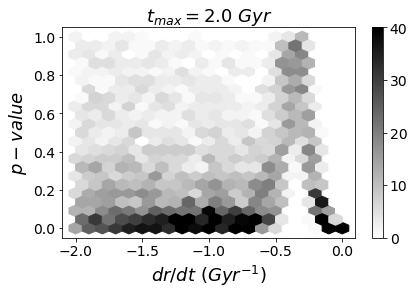

In [8]:
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=2,drdt_step=0.05,nrandom=100)

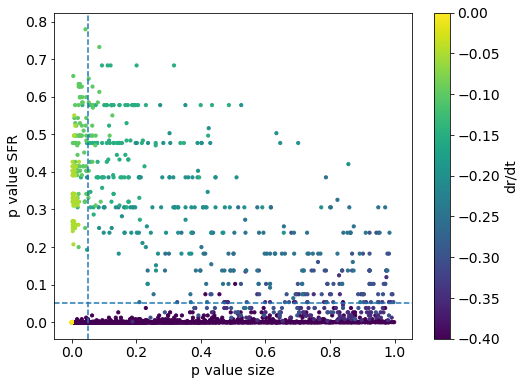

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=10,vmin=-.4,vmax=0)
plt.xlabel('p value size')
plt.ylabel('p value SFR')
plt.colorbar(label='dr/dt')
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
ax = plt.gca()
#ax.set_yscale('log')
plt.savefig('pvalue-SFR-size-tmax2.0Gyr-shrink0.png')

## running with simpler integration scheme ##

- we shrink the effective radius according to dr/dt and radomly assigned infall time
- using ratio of surface areas between infall and sim_core galaxies, we scale the SFR of infall galaxies
  - 1 = integrating the sersic profile of the infall galaxy
  - 2 = integrating the sersic profile of the sim_core galaxy
  - scale the SFR of the infall galaxy by the ratio 2/1
- basically, this removes too much star formation
  - we don't find any solutions that simultaneously reproduce the distribution of sizes and SFRs of the core galaxies.
  - the simulations that do a good job matching the distribution of sizes in the core

best dr/dt =  -1.9
disk is quenched in 0.5 Gyr
fraction that are quenched = 0.75
KS p value = 9.99992445e-01


<Figure size 432x288 with 0 Axes>

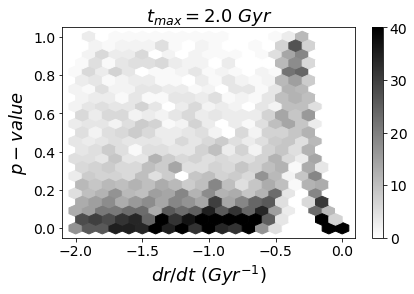

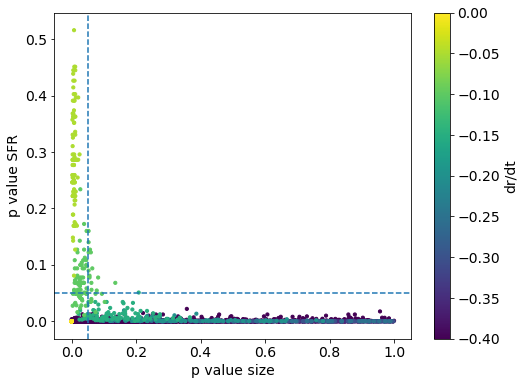

In [10]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py 
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=2,drdt_step=0.05,nrandom=100)
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=10,vmin=-.4,vmax=0)
plt.xlabel('p value size')
plt.ylabel('p value SFR')
plt.colorbar(label='dr/dt')
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
ax = plt.gca()
#ax.set_yscale('log')
plt.savefig('pvalue-SFR-size-tmax2.0Gyr-shrinkorig.png')

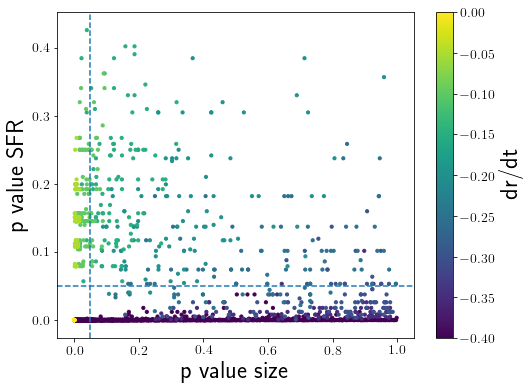

In [82]:
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=10,vmin=-.4,vmax=0)
plt.xlabel('p value size')
plt.ylabel('p value SFR')
plt.colorbar(label='dr/dt')
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
ax = plt.gca()
#ax.set_yscale('log')
plt.savefig('pvalue-SFR-size-tmax2.0Gyr-shrink0.png')

In [92]:
ks_2samp(sizes['fcnsersic1'][core_flag],sizes['fcnsersic1'][~core_flag])

Ks_2sampResult(statistic=0.09131652661064425, pvalue=0.6973441666424081)

## Comparing distribution of sersic indices of core and external galaxies ##

- we are assuming that these are comparable in our modeling, and I want to make sure this is the case

/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


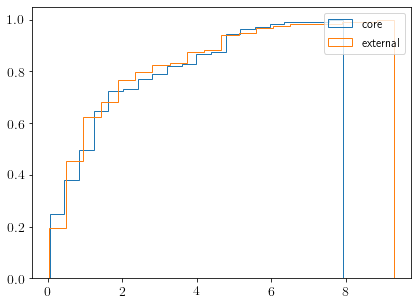

In [95]:
plt.figure()

plt.hist(sizes['fcnsersic1'][core_flag],histtype='step',label='core',cumulative=True,normed=True,bins=20)
plt.hist(sizes['fcnsersic1'][~core_flag],histtype='step',label='external',cumulative=True,normed=True,bins=20)
plt.legend()

# Running Simulations - Model 1 #

best dr/dt =  -0.6999999999999988
disk is quenched in 1.4 Gyr
fraction that are quenched = 0.19
KS p value = 9.99835962e-01


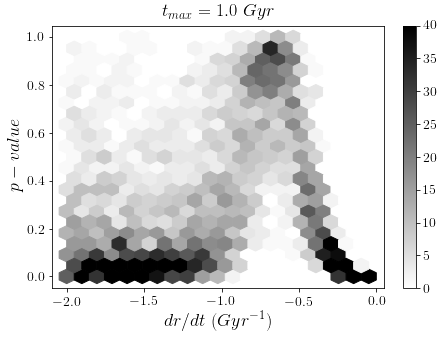

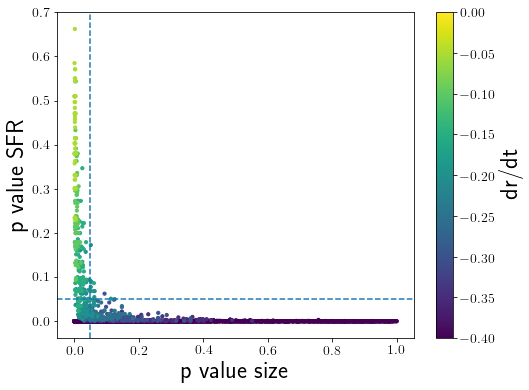

In [281]:
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=1,drdt_step=0.05,nrandom=100)
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=10,vmin=-.4,vmax=0)
plt.xlabel('p value size')
plt.ylabel('p value SFR')
plt.colorbar(label='dr/dt')
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
ax = plt.gca()
#ax.set_yscale('log')
plt.savefig('pvalue-SFR-size-tmax1.0Gyr-shrink0.png')

Welcome!


<Figure size 489.6x360 with 0 Axes>

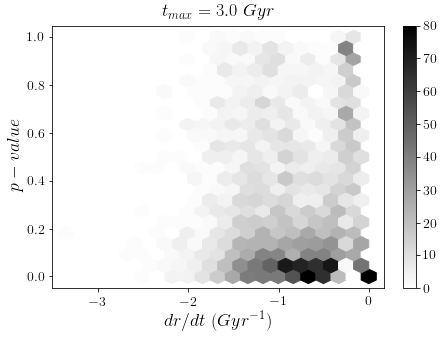

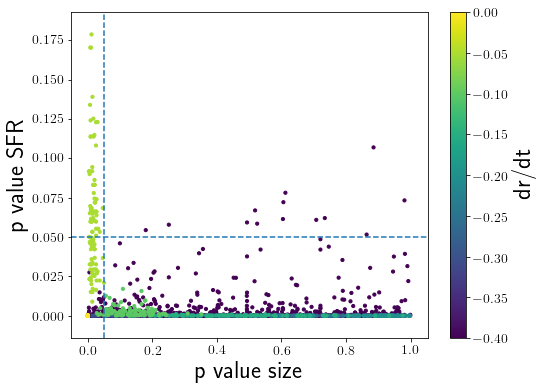

In [6]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py 
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=3,drdt_step=0.05,nrandom=100)
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=10,vmin=-.4,vmax=0)
plt.xlabel('Constraint from size of SF disk (p value)')
plt.ylabel('Constraint from Total SFR (p value)')
plt.colorbar(label='dr/dt')
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
ax = plt.gca()
#ax.set_yscale('log')
plt.savefig('adap2020-timescale.png')
plt.savefig('adap2020-timescale.pdf')

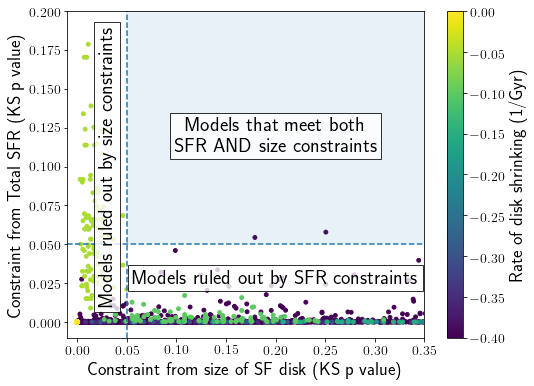

In [59]:
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=15,vmin=-.4,vmax=0)
plt.xlabel('Constraint from size of SF disk (KS p value)',fontsize=18)
plt.ylabel('Constraint from Total SFR (KS p value)',fontsize=18)
cb = plt.colorbar(label='Rate of disk shrinking (1/Gyr)')
cb.set_label('Rate of disk shrinking (1/Gyr)',fontsize=18)
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
ax = plt.gca()
plt.axis([-.01,.35,-.01,.2])
xl = np.linspace(.05,1,100)
y1 = np.ones(len(xl))
y2 = .05*np.ones(len(xl))
plt.fill_between(xl,y1=y1,y2=y2,alpha=.1)
plt.text(.2,.11,'Models that meet both \nSFR AND size constraints',horizontalalignment='center',bbox=dict(facecolor='white', alpha=0.8))
plt.text(.2,.025,'Models ruled out by SFR constraints',horizontalalignment='center',bbox=dict(facecolor='white', alpha=0.8))
plt.text(.03,.1,'Models ruled out by size constraints',verticalalignment='center',horizontalalignment='center',rotation=90,bbox=dict(facecolor='white', alpha=0.8))
#ax.set_yscale('log')
plt.savefig('adap2020-timescale.png')
plt.savefig('adap2020-timescale.pdf')

best dr/dt =  -1.9
disk is quenched in 0.5 Gyr
fraction that are quenched = 0.80
KS p value = 9.99888517e-01


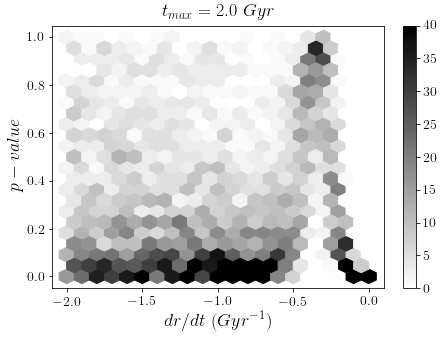

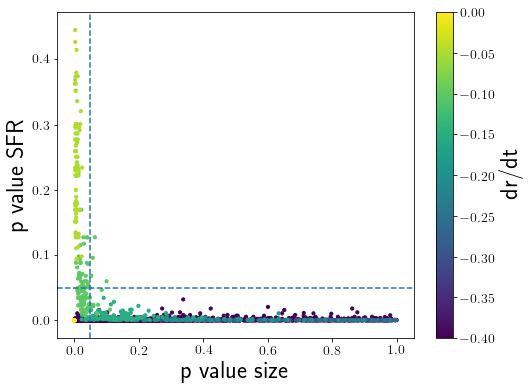

In [282]:
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=2,drdt_step=0.05,nrandom=100)
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=10,vmin=-.4,vmax=0)
plt.xlabel('p value size')
plt.ylabel('p value SFR')
plt.colorbar(label='dr/dt')
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
ax = plt.gca()
#ax.set_yscale('log')
plt.savefig('pvalue-SFR-size-tmax2.0Gyr-shrink0.png')

best dr/dt =  -0.1999999999999984
disk is quenched in 5.0 Gyr
fraction that are quenched = 0.11
KS p value = 9.98300242e-01


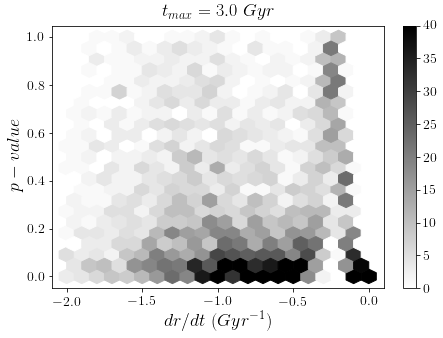

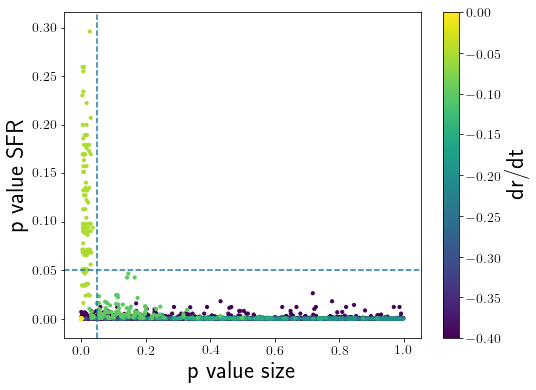

In [283]:
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=3,drdt_step=0.05,nrandom=100)
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=10,vmin=-.4,vmax=0)
plt.xlabel('p value size')
plt.ylabel('p value SFR')
plt.colorbar(label='dr/dt')
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
ax = plt.gca()
#ax.set_yscale('log')
plt.savefig('pvalue-SFR-size-tmax3.0Gyr-shrink0.png')

/home/rfinn/github/LCS/python/Python3/LCSsimulate-infall-paper2.py:146: RuntimeWarning: invalid value encountered in power
  x_after = bn*(ratio_after)**(1./n)


best dr/dt =  -0.849999999999999
disk is quenched in 1.2 Gyr
fraction that are quenched = 0.71
KS p value = 9.99660959e-01


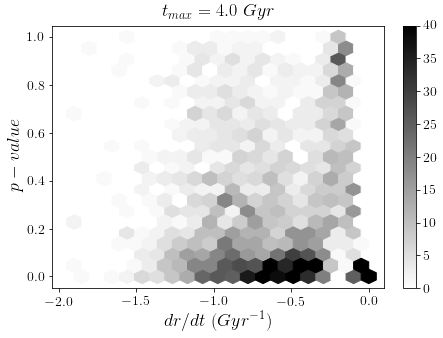

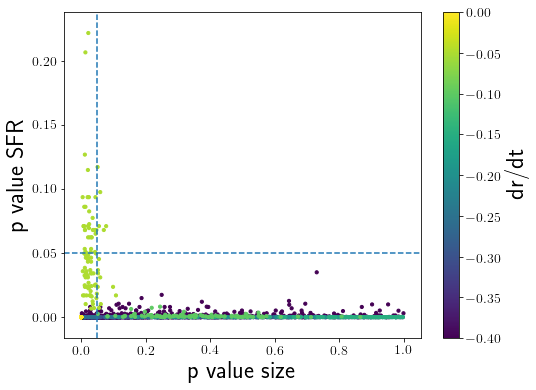

In [284]:
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=4,drdt_step=0.05,nrandom=100)
plt.figure(figsize=(8,6))
plt.scatter(all_p,all_p_sfr,c=all_drdt,s=10,vmin=-.4,vmax=0)
plt.xlabel('p value size')
plt.ylabel('p value SFR')
plt.colorbar(label='dr/dt')
plt.axhline(y=.05,ls='--')
plt.axvline(x=.05,ls='--')
ax = plt.gca()
#ax.set_yscale('log')
plt.savefig('pvalue-SFR-size-tmax4.0Gyr-shrink0.png')

/home/rfinn/github/LCS/python/Python3/LCSsimulate-infall-paper2.py:146: RuntimeWarning: invalid value encountered in power
  x_after = bn*(ratio_after)**(1./n)


best dr/dt =  -0.5499999999999987
disk is quenched in 1.8 Gyr
fraction that are quenched = 0.12
KS p value = 9.95824017e-01
best dr/dt =  -1.2499999999999993
disk is quenched in 0.8 Gyr
fraction that are quenched = 0.62
KS p value = 9.99430321e-01
best dr/dt =  -1.4499999999999995
disk is quenched in 0.7 Gyr
fraction that are quenched = 0.79
KS p value = 9.97218857e-01
best dr/dt =  -0.849999999999999
disk is quenched in 1.2 Gyr
fraction that are quenched = 0.75
KS p value = 9.99218253e-01


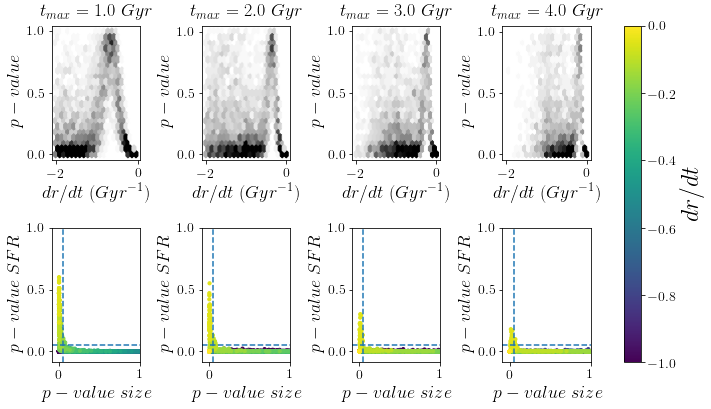

In [280]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24
plot_multiple_tmax_wsfr(nrandom=100)

# Fitting truncated Sersic profiles in 1D #

- generated sersic profiles based on properties on external 24um fits
- truncated each to a random amount between 0.25 and 5 Re
- fit truncated models with sersic profile
- save results
- program: fit-truncated-sersic-1d.py



trouble with that fit


trouble with that fit


trouble with that fit


trouble with that fit


trouble with that fit


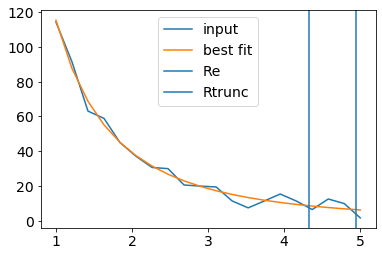

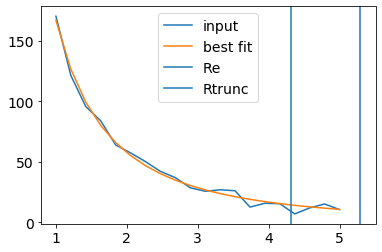

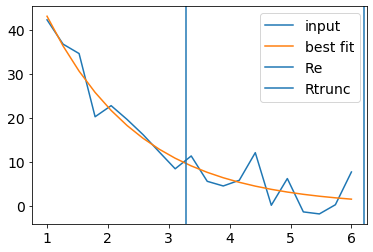

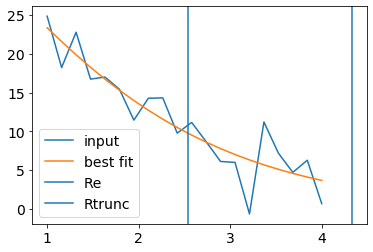

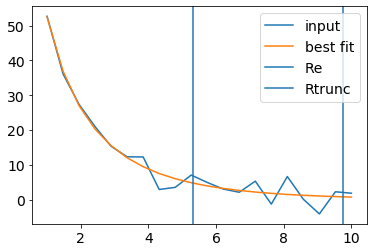

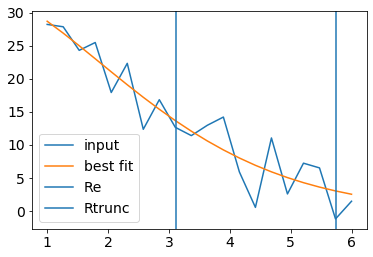

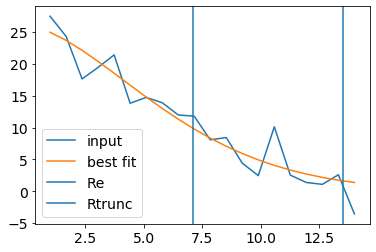

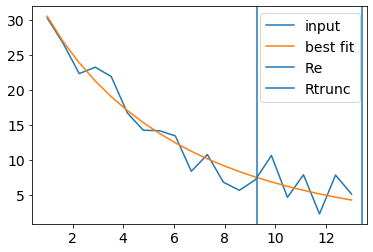

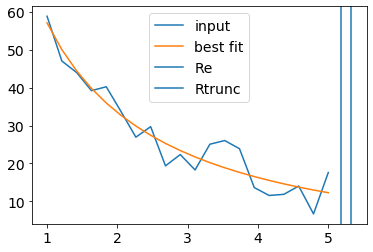

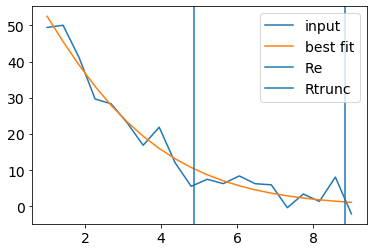

In [13]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/fit-truncated-sersic-1d.py --nres 20 --ngal 10 --minrtrunc .75 --maxrtrunc 1

## updating truncation simulation ##

- we set the intensity of the truncated profile to zero outside the truncation radius
- we are fitting the profile out to 6 Re (by default)
- previously, we were only fitting out to the truncation radius
- I am no longer using 24um properties of the external sample to seed the simulation.  Instead, I set Re to 5 and Ie to 2 for all galaxies, and then vary truncation radius and n among the different trials.

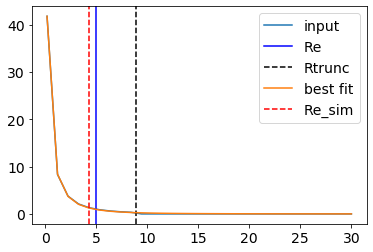

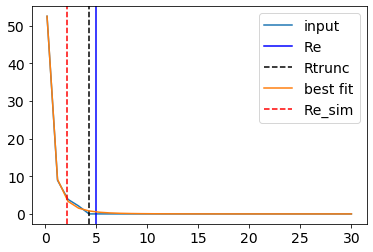

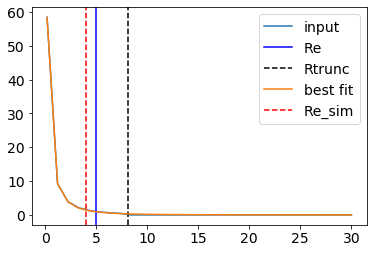

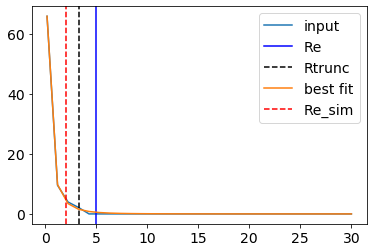

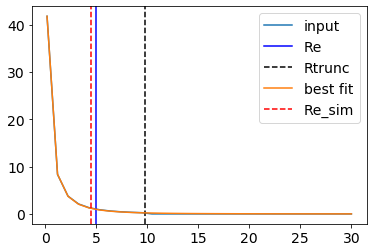

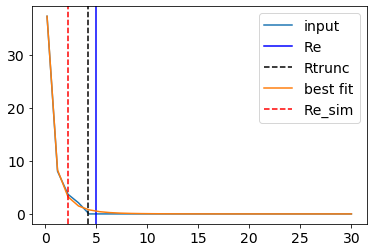

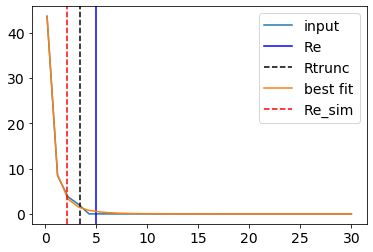

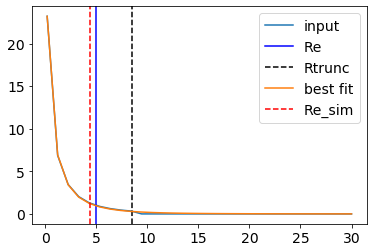

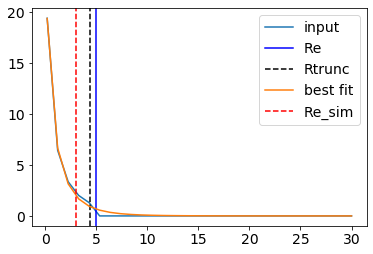

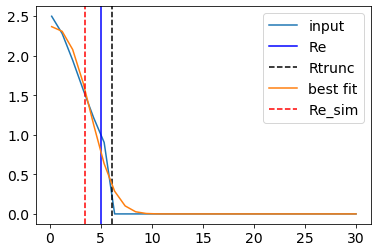

In [23]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/fit-truncated-sersic-1d.py --nres 30 --ngal 10 --minrtrunc .5 --maxrtrunc 2
plt.show()

## translating between truncation radius and inferred Re ##

- we are fitting a truncated profile with a sersic profile
- the plots below show that the sersic fit of a truncated profile will have a lower value of Re than that of the underlying/non-truncated profile
- in addition, the sersic fit to a truncated sersic profile will have a boosted Ie, and lower n.  The effect on Ie is the least pronounced.

fitting R/Re vs truncation radius with y = a-b*exp(-c*x/d):  [1.03179629 1.49588586 1.23861193]


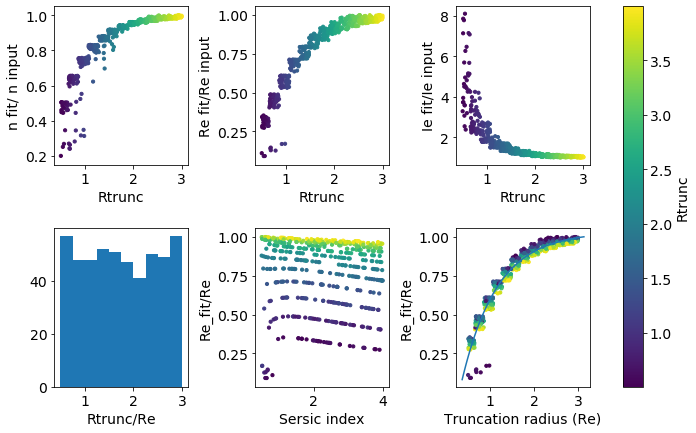

In [108]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/fit-truncated-sersic-1d.py --nres 30 --ngal 500 --minrtrunc .5 --maxrtrunc 3 
plt.show()

fitting vs truncation radius with y = a+b*exp(c*x):  [ 1.00198564 -1.47774914 -1.65656873]
fitting vs truncation radius with y = a+b*exp(c*x):  [ 1.00492674 -1.64793246 -1.40501981]
fitting vs truncation radius with y = a+b*exp(c*x):  [ 1.03676508 23.87434954 -3.11509669]


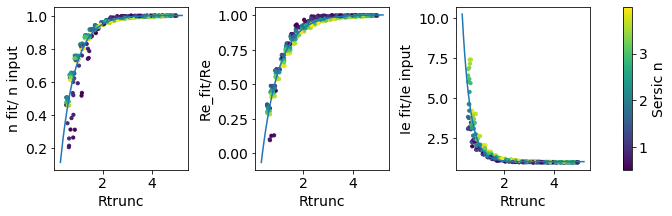

In [179]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/fit-truncated-sersic-1d.py --nres 30 --ngal 500 --minrtrunc .5 --maxrtrunc 5 
plt.show()

# Model 2: New strategy for simulation #

- take field galaxy
- pick random dr/dt, where dr/dt is how fast the radius is truncated
  - assuming it starts at 6 (encloses 95% for an n=4 profile.  enclosed flux is higher for lower n profiles).
  - outer limit of integral is dr/dt times 6Re(time since infall)
  - QUESTION ABOUT HOW TO IMPLEMENT THIS - 
    - is dr/dt the rate at which Rtrunc/Re changes (this is how I have coded it), or the rate at which Rtrunc changes (this would need to be in physical units, and this would make it more complicated)
  
- to compare sizes, take truncated radius and use fitting function to translate into Re_fit/Re_input. this predicts the effective radius we would get by fitting a single component sersic profile to the truncated profile.

- to compare SFRs:
  - integrate original profile out to 6 Re
  - integrate the simulated core profile out to $Rtrunc \times R_e$
  
- alternate method for computing new SFR:
  - use all parameters (n, Re, Ie) associated with the truncation radius
  - integrate corresponding sersic profile from r=0 to 6Re
  - compare
  
- plot integral of truncated profile (out to rtrunc)/ integral best-fit sersic model (out to 6Re) VS Rtrunc
  - do these give the same result?
  - if yes, then our two ways of estimating the change in SFR are consistent

# Third Model #
- if model two fits the change in Re but can't simultaneously fit the change in SFR, then we can try adding a boost to model 2.

# Plotting #
- change the format of the plots that we showed in paper 1
- rather than showing the hexbin distribution of p value vs dr/dt, show fraction of trials at a particular dr/dt that have a p value < 0.05
- could make this even lower threshold, e.g. p value < .003


# Implementing Model 2 #

Welcome!
USING MODEL 2
best dr/dt =  -3.95
disk is quenched in 0.3 Gyr
fraction that are quenched = 0.00
KS p value = 5.48005310e-03
drdt multiple values of dr/dt
#################
	 best dr/dt =  -3.95
	 disk is quenched in 0.3 Gyr
USING MODEL 2
best dr/dt =  -4.0
disk is quenched in 0.2 Gyr
fraction that are quenched = 0.29
KS p value = 9.95815221e-01
USING MODEL 2
best dr/dt =  -3.3500000000000023
disk is quenched in 0.3 Gyr
fraction that are quenched = 0.50
KS p value = 9.98028481e-01
USING MODEL 2
best dr/dt =  -3.750000000000001
disk is quenched in 0.3 Gyr
fraction that are quenched = 0.60
KS p value = 9.98620662e-01


<Figure size 432x288 with 0 Axes>

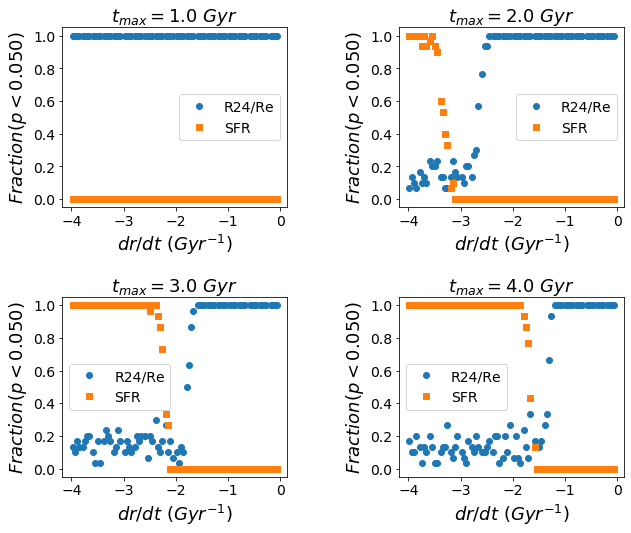

In [178]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 2 --tmax 3
plot_multiple_tmax_wsfr2(nrandom=30)

## Alternate method for calculating change in SFR ##

- alternate method for computing new SFR:
  - use all parameters (n, Re, Ie) associated with the truncation radius
  - integrate corresponding sersic profile from r=0 to 6Re
  - compare
  
## Result ##

This definitely gives different results.  It seems to me that method one is more physical, but method 2 is closer to what we do with the data.  Except we get SFRs from the MIPS flux and NUV flux from NSA.  We don't use the galfit magnitude to calculate the SFR.
  

Welcome!
USING MODEL 2
best dr/dt =  -3.95
disk is quenched in 0.3 Gyr
fraction that are quenched = 0.00
KS p value = 5.48005310e-03
drdt multiple values of dr/dt
#################
	 best dr/dt =  -3.95
	 disk is quenched in 0.3 Gyr
#################
	 best dr/dt =  -3.8500000000000005
	 disk is quenched in 0.3 Gyr
USING MODEL 2
best dr/dt =  -3.0500000000000034
disk is quenched in 0.3 Gyr
fraction that are quenched = 0.08
KS p value = 9.84678073e-01
USING MODEL 2
best dr/dt =  -2.7000000000000046
disk is quenched in 0.4 Gyr
fraction that are quenched = 0.35
KS p value = 9.97041775e-01
USING MODEL 2
best dr/dt =  -3.3500000000000023
disk is quenched in 0.3 Gyr
fraction that are quenched = 0.50
KS p value = 9.96839538e-01


<Figure size 432x288 with 0 Axes>

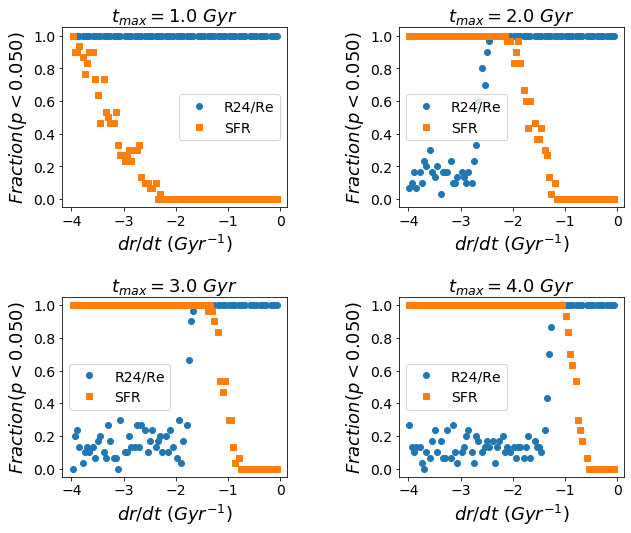

In [177]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 2 --tmax 3 --sfrint 2
plot_multiple_tmax_wsfr2(nrandom=30)

Welcome!
USING MODEL 2
best dr/dt =  -3.9000000000000004
disk is quenched in 0.3 Gyr
fraction that are quenched = 0.00
KS p value = 4.73440817e-03
USING MODEL 2
best dr/dt =  -3.750000000000001
disk is quenched in 0.3 Gyr
fraction that are quenched = 0.30
KS p value = 8.90153250e-01
USING MODEL 2
best dr/dt =  -2.9500000000000037
disk is quenched in 0.3 Gyr
fraction that are quenched = 0.34
KS p value = 9.97234694e-01
USING MODEL 2
best dr/dt =  -4.0
disk is quenched in 0.2 Gyr
fraction that are quenched = 0.52
KS p value = 9.95462257e-01


<Figure size 432x288 with 0 Axes>

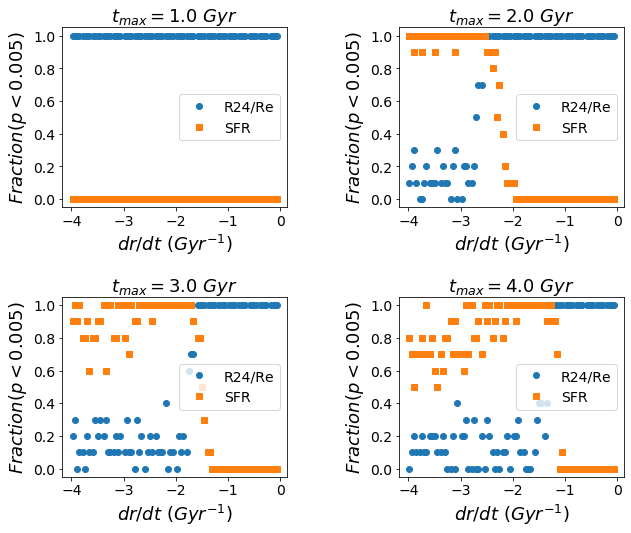

In [185]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 2 --tmax 3 --sfrint 2
plot_multiple_tmax_wsfr2(nrandom=10)

Welcome!
USING MODEL 2
drdt multiple values of dr/dt
#################
	 best dr/dt =  -3.9000000000000004
	 disk is quenched in 0.3 Gyr
USING MODEL 2
USING MODEL 2
USING MODEL 2


<Figure size 432x288 with 0 Axes>

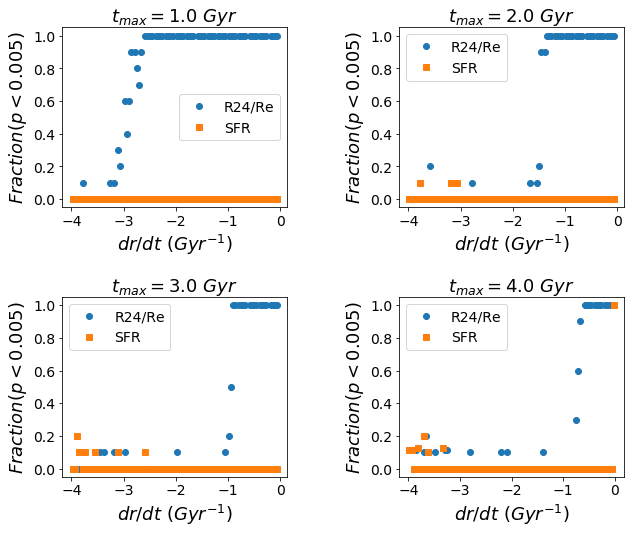

In [190]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --rmax 4 --use24 --model 2 --tmax 3 --sfrint 1
plot_multiple_tmax_wsfr2(nrandom=10)

Found that I had the limit se

Welcome!
USING MODEL 2
USING MODEL 2
USING MODEL 2
USING MODEL 2


<Figure size 432x288 with 0 Axes>

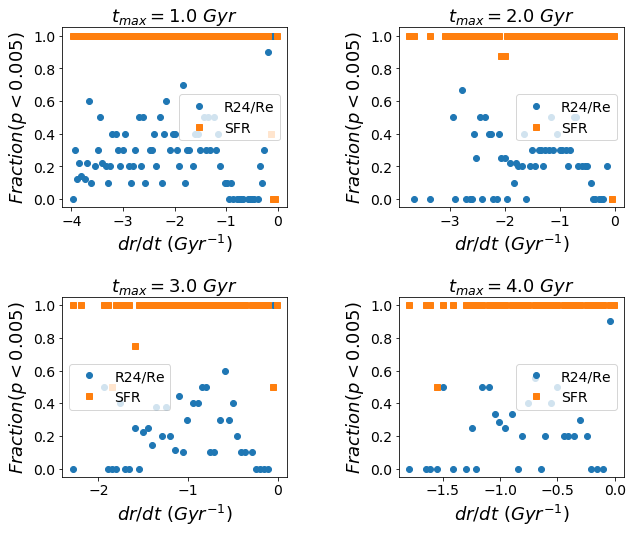

In [6]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --rmax 4 --use24 --model 2 --tmax 3 --sfrint 1
plot_multiple_tmax_wsfr2(nrandom=10)

# Update July 21, 2020 #

* need to restrict to B/T < 0.3 galaxies
* do this and then rerun models 1 and 2
* then run model 3




## Model 1 with B/T < 0.3 only ##

Welcome!


<Figure size 432x288 with 0 Axes>

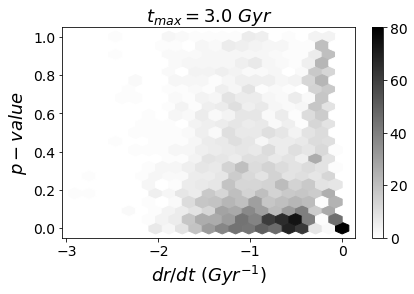

In [10]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=3,drdt_step=0.05,nrandom=100)

Welcome!


<Figure size 432x288 with 0 Axes>

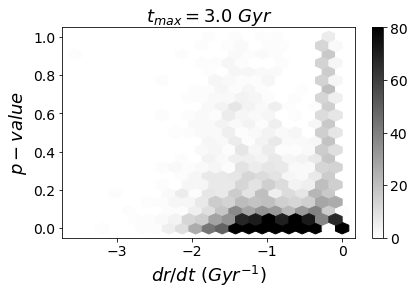

In [11]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --btcut --use24
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr = run_sim(tmax=3,drdt_step=0.05,nrandom=100)

## Model 2 with B/T < 0.3 only ##

* first rechecking to make sure we get the same results as before, and that I didn't inadvertently change something.

Welcome!


<Figure size 432x288 with 0 Axes>

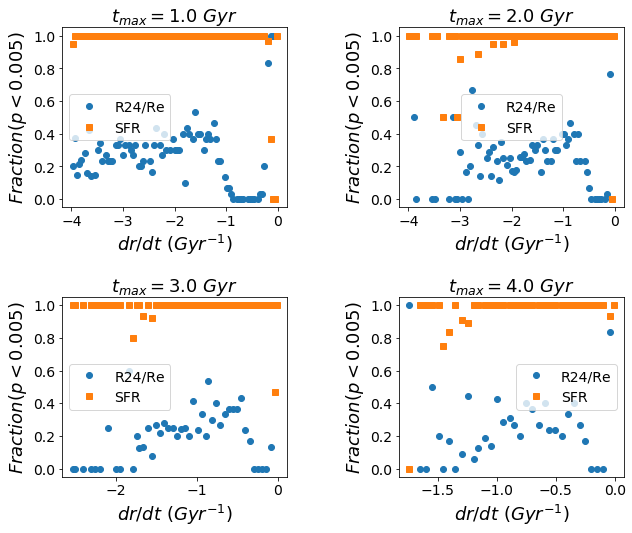

In [18]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 1 --tmax 3 --sfrint 1
plot_multiple_tmax_wsfr2(nrandom=30)

Welcome!


<Figure size 432x288 with 0 Axes>

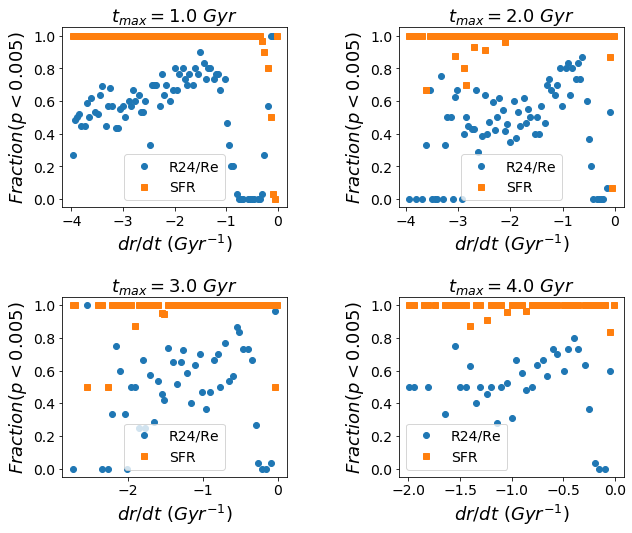

In [19]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 1 --tmax 3 --sfrint 1 --btcut
plot_multiple_tmax_wsfr2(nrandom=30)

## Testing new plot for models 1 and 2 ##

* 22-July-2020

In [154]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 1 --tmax 3 --sfrint 1 --btcut
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr=run_sim(tmax=tmax,drdt_step=.05,nrandom=30,plotsingle=False,plotflag=False)


Welcome!


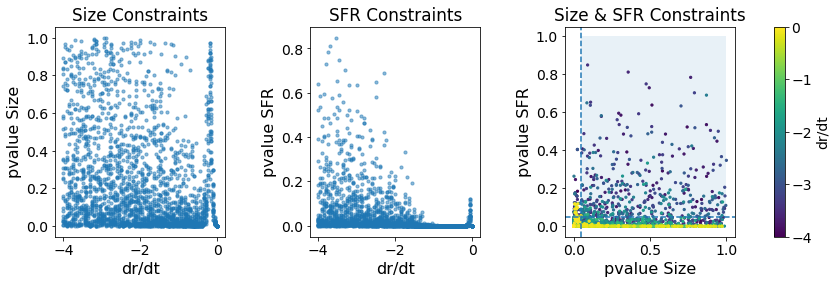

In [155]:
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=1)

# Model 3 #

* model 3 is the same as model 2 (truncated disk) BUT we add a boost factor to the central intensity
* want to plot dr/dt vs boost.  maybe color code if p-value for both are below 0.05 (Greg's suggestion -  to make it 2 colors)
  * could also do as a first step:  p-value vs pvalue, 2x1, left color coded by dr/dt, right color coded by boost
  * then move on to the second version

Welcome!


<Figure size 432x288 with 0 Axes>

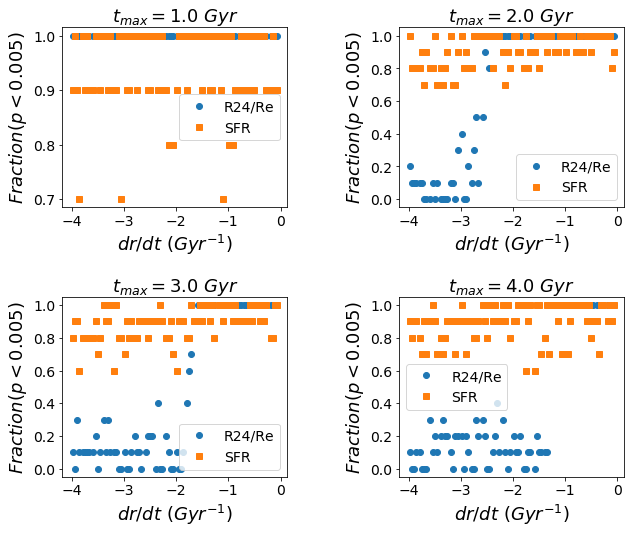

In [28]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 3 --tmax 3 --sfrint 1 --btcut
plot_multiple_tmax_wsfr2(nrandom=10)

In [42]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 3 --tmax 3 --sfrint 1 --btcut
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr,boost=run_sim(tmax=tmax,drdt_step=.05,nrandom=30,plotsingle=False,plotflag=False)

Welcome!


<Figure size 432x288 with 0 Axes>

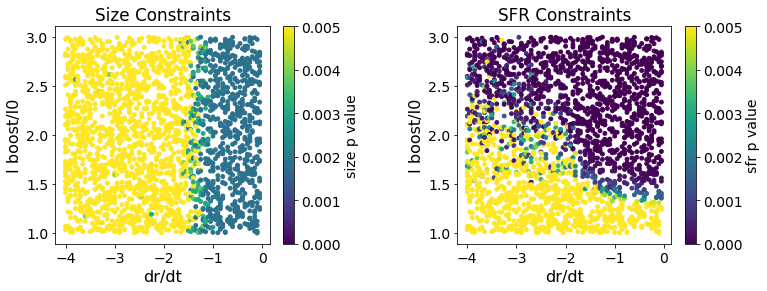

In [55]:
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr,boost=run_sim(tmax=tmax,drdt_step=.05,nrandom=30,plotsingle=False,plotflag=False)
plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=.5)
colors = [all_p,all_p_sfr]
labels = ['size p value','sfr p value']
titles = ['Size Constraints','SFR Constraints']
v2 = .005
for i in range(len(colors)):
    plt.subplot(1,2,i+1)
    plt.scatter(all_drdt,boost,c=colors[i],vmin=0,vmax=v2,s=15)
    cb = plt.colorbar()
    cb.set_label(labels[i])
    plt.title(titles[i])
    plt.xlabel('dr/dt',fontsize=16)
    plt.ylabel('I boost/I0',fontsize=16)
plt.savefig(plotdir+'/model3-tmax'+str(tmax)+'-size-sfr-constraints.png')
plt.savefig(plotdir+'/model3-tmax'+str(tmax)+'-size-sfr-constraints.pdf')


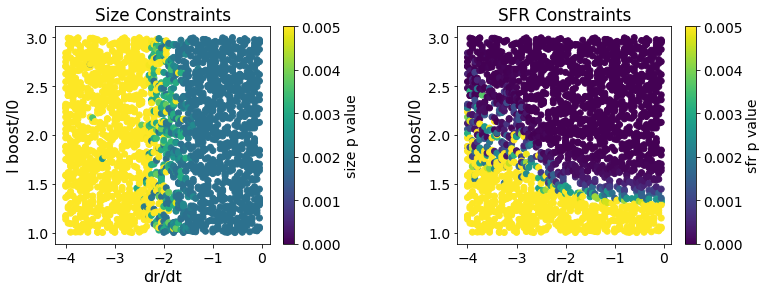

In [49]:
tmax=2
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr,boost=run_sim(tmax=tmax,drdt_step=.05,nrandom=30,plotsingle=False,plotflag=False)


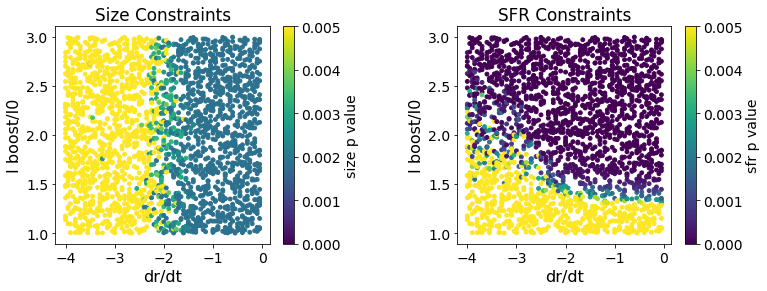

In [51]:
plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=.5)
colors = [all_p,all_p_sfr]
labels = ['size p value','sfr p value']
titles = ['Size Constraints','SFR Constraints']
v2 = .005
for i in range(len(colors)):
    plt.subplot(1,2,i+1)
    plt.scatter(all_drdt,boost,c=colors[i],vmin=0,vmax=v2,s=15)
    cb = plt.colorbar()
    cb.set_label(labels[i])
    plt.title(titles[i])
    plt.xlabel('dr/dt',fontsize=16)
    plt.ylabel('I boost/I0',fontsize=16)
plt.savefig(plotdir+'/model3-tmax'+str(tmax)+'-size-sfr-constraints.png')
plt.savefig(plotdir+'/model3-tmax'+str(tmax)+'-size-sfr-constraints.pdf')


# SUMMARIZING RESULTS (8/7/20) #

* going to run through simulations, both with and w/out B/T cut
* use our 24um + NUV SFRs
* going to run the following simulations, and summarize the results

| Model |description | t_max | rmax |  without B/T cut | with B/T cut |
|-----|--|------|----|--|--|
| 1 | homologous | 3 |N/A | few acceptable models |similar results |
| 1b | homologous with boost | 3 | N/A | need to implement this|
| 2 | truncation |  3| 4 |discriminating power is from size, not SFRs, although SFRs show trend.  might be losing too many galaxies at the highest values of dr/dt, meaning the truncated SFRs are below our detection limit.| results are similar, although structure in the SFR p-value vs drdt is different.  weird numerical effects with no bt cut.| 
| 2b | truncation w/boost | 3 |4 | most of discriminating power is from size.  SFRs limit the amount of boosting.|similar results |

## Model 1, no B/T cut, Spitzer SFRs ##

USING MIPS+GALEX NUV SFRS

MIN SFR =  0.04905401916616373

Using 24um sizes (this is the right thing to do)

Welcome!


<Figure size 432x288 with 0 Axes>

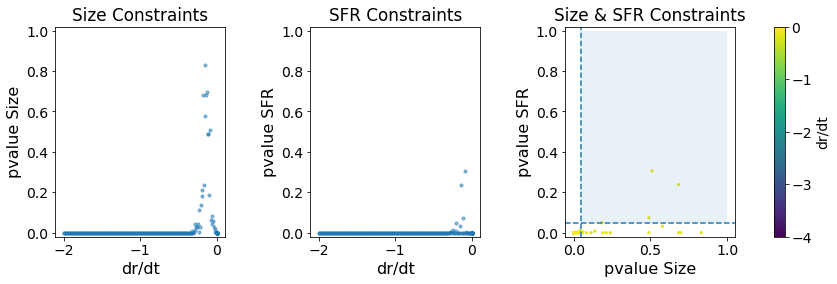

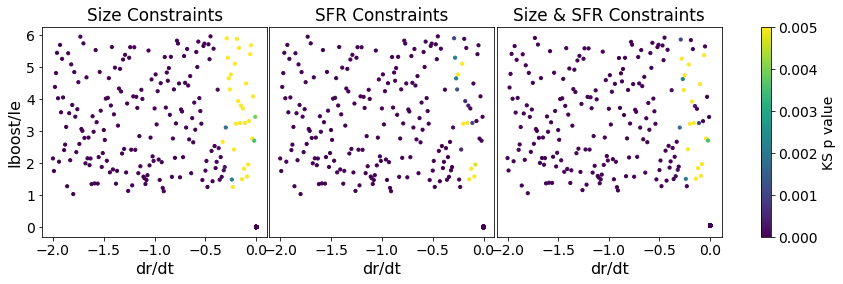

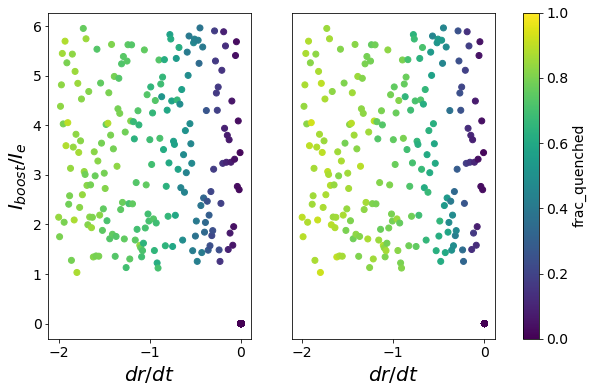

In [150]:

os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py
tmax=3
drdtstep=.01
nrandom=30
all_drdt,all_p,all_p_sfr,all_boost,fquench_size,fquench_sfr=\
run_sim(model=1,drdtmin=-2,boostflag=True,maxboost=5,tmax=tmax,drdt_step=drdtstep,nrandom=10,rmax=4,plotsingle=False,plotflag=False)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=tmax,v2=.005,model=1)
plot_model3_3panel(all_drdt,all_p,all_p_sfr, all_boost, tmax=tmax,v2=.005)
plot_quenched_fraction(all_drdt,all_boost,fquench_size, fquench_sfr)

USING MIPS+GALEX NUV SFRS

MIN SFR =  0.04905401916616373

Using 24um sizes (this is the right thing to do)

Welcome!
USING MODEL 2


<Figure size 432x288 with 0 Axes>

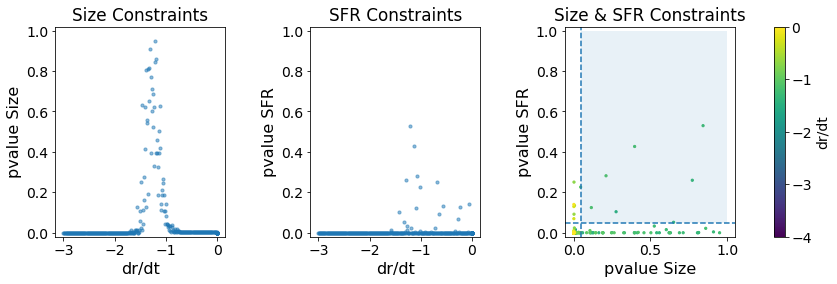

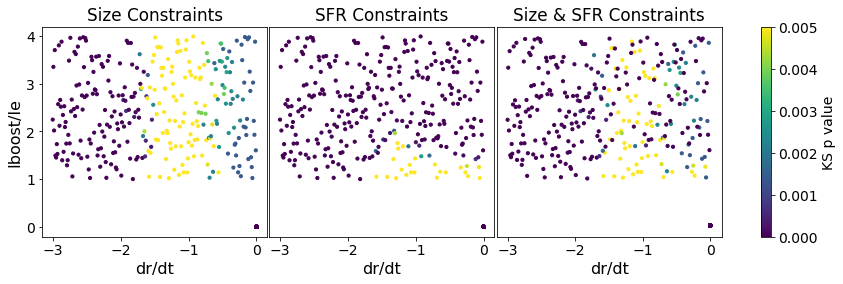

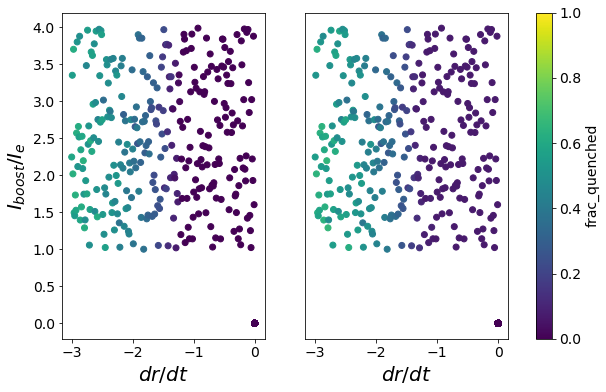

In [152]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py
tmax=3
drdtstep=.01
nrandom=30
model=2
all_drdt,all_p,all_p_sfr,all_boost,fquench_size,fquench_sfr=\
run_sim(model=model,drdtmin=-3,boostflag=True,maxboost=3,tmax=tmax,drdt_step=drdtstep,nrandom=10,rmax=4,plotsingle=False,plotflag=False)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=tmax,v2=.005,model=model)
plot_boost_3panel(all_drdt,all_p,all_p_sfr, all_boost, tmax=tmax,v2=.005)
plot_quenched_fraction(all_drdt,all_boost,fquench_size, fquench_sfr)

USING MIPS+GALEX NUV SFRS

MIN SFR =  0.04905401916616373

Using 24um sizes (this is the right thing to do)

Welcome!


<Figure size 432x288 with 0 Axes>

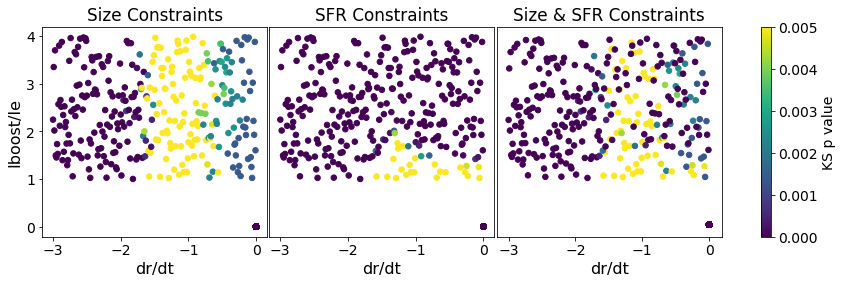

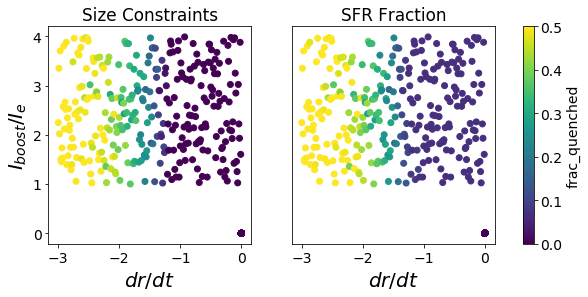

In [158]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py
plot_boost_3panel(all_drdt,all_p,all_p_sfr, all_boost, tmax=tmax,v2=.005)
plot_quenched_fraction(all_drdt,all_boost,fquench_size, fquench_sfr)


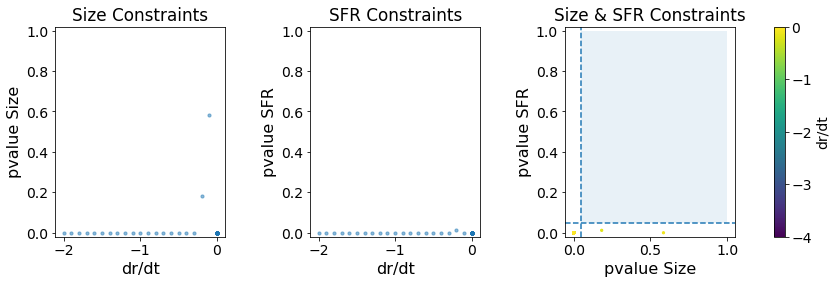

In [138]:
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=1)

USING MIPS+GALEX NUV SFRS

MIN SFR =  0.04905401916616373

Using 24um sizes (this is the right thing to do)

Welcome!


<Figure size 432x288 with 0 Axes>

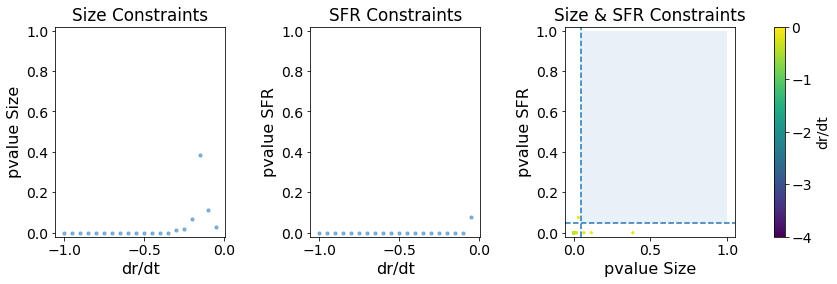

In [133]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py
tmax=3
drdtstep=.05
nrandom=30
maxboost=10
all_drdt,all_p,all_p_sfr,all_boost,fquench_size,fquench_sfr=run_sim(model=1,drdtmin=-1,boostflag=True,maxboost=maxboost,tmax=tmax,drdt_step=drdtstep,nrandom=nrandom,rmax=4,plotsingle=False,plotflag=False)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=1)


## Model 1, B/T cut, Spitzer SFRs ##

core vs external: size distribution
KS test: 0.20, p=8.09e-02
core vs external: SFR distribution
KS test: 0.09, p=8.65e-01
core vs external: n sersic distribution
KS test: 0.10, p=7.39e-01
Welcome!


<Figure size 432x288 with 0 Axes>

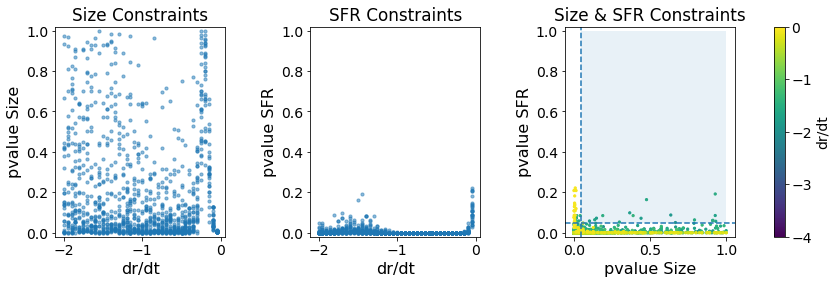

In [41]:
os.chdir(homedir+'/research/LCS/plots/')
mmodel=1
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --model 1 --btcut
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr=run_sim(tmax=tmax,drdt_step=.05,nrandom=30,rmax=4,plotsingle=False,plotflag=False)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=1)

USING MIPS+GALEX NUV SFRS

Using 24um sizes (this is the right thing to do)


core vs external: size distribution
KS Test:
D =   0.27
p-vale = 1.835e-03 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   0.68
p-vale = 0.17449 (prob that samples are from same distribution)

core vs external: SFR distribution
KS Test:
D =   0.18
p-vale = 9.894e-02 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.24
p-vale = 0.44567 (prob that samples are from same distribution)

core vs external: n sersic distribution
KS Test:
D =   0.12
p-vale = 4.463e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.28
p-vale = 0.46762 (prob that samples are from same distribution)

Welcome!


<Figure size 432x288 with 0 Axes>

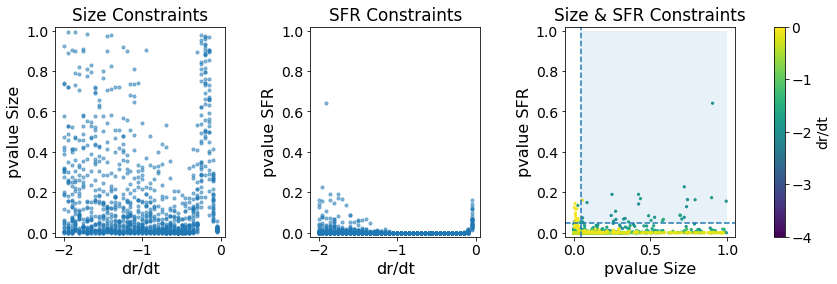

In [22]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --btcut
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr, all_boost=run_sim(model=1,tmax=tmax,drdt_step=.05,nrandom=30,rmax=4,plotsingle=False,plotflag=False)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=1)

## Model 2, no B/T cut, Spitzer SFRs, rmax=4 ##

USING MIPS+GALEX NUV SFRS

Using 24um sizes (this is the right thing to do)


core vs external: size distribution
KS Test:
D =   0.15
p-vale = 1.246e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   0.95
p-vale = 0.13249 (prob that samples are from same distribution)

core vs external: SFR distribution
KS Test:
D =   0.15
p-vale = 1.221e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.32
p-vale = 0.48478 (prob that samples are from same distribution)

core vs external: n sersic distribution
KS Test:
D =   0.16
p-vale = 1.083e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.79
p-vale = 0.80793 (prob that samples are from same distribution)

Welcome!
USING MODEL 2


<Figure size 432x288 with 0 Axes>

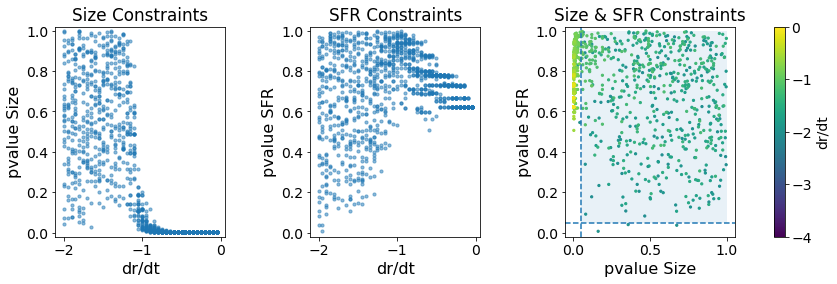

In [25]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py 
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr,all_boost=run_sim(model=2,tmax=tmax,drdt_step=.05,nrandom=30,rmax=4,plotsingle=False,plotflag=False)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=2)

## Model 2, B/T cut, Spitzer SFRs, rmax=4 ##

USING MIPS+GALEX NUV SFRS

Using 24um sizes (this is the right thing to do)


core vs external: size distribution
KS Test:
D =   0.15
p-vale = 2.176e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   0.68
p-vale = 0.17449 (prob that samples are from same distribution)

core vs external: SFR distribution
KS Test:
D =   0.16
p-vale = 1.892e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.24
p-vale = 0.44567 (prob that samples are from same distribution)

core vs external: n sersic distribution
KS Test:
D =   0.14
p-vale = 2.915e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.28
p-vale = 0.46762 (prob that samples are from same distribution)

Welcome!
USING MODEL 2


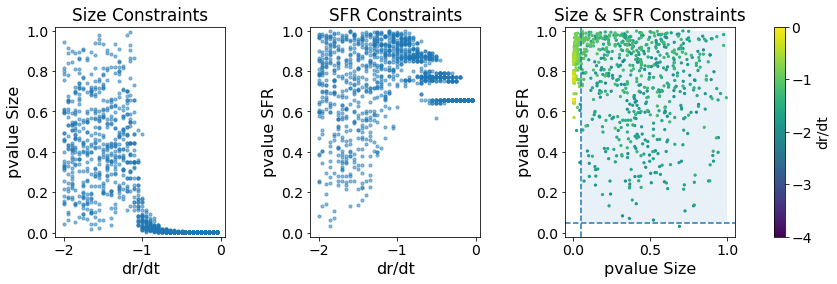

In [28]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --btcut
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr,all_boost=run_sim(model=2,tmax=tmax,drdt_step=.05,nrandom=30,rmax=4,plotsingle=False,plotflag=False)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=2)

## Model 1, w/boost, no B/T cut, Spitzer SFRs, rmax=4 ##

USING MIPS+GALEX NUV SFRS

MIN SFR =  0.04905401916616373

Using 24um sizes (this is the right thing to do)


core vs external: size distribution
KS Test:
D =   0.32
p-vale = 1.222e-05 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   5.02
p-vale = 0.00356 (prob that samples are from same distribution)

core vs external: SFR distribution
KS Test:
D =   0.16
p-vale = 9.978e-02 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.32
p-vale = 0.48478 (prob that samples are from same distribution)

core vs external: Re 24
KS Test:
D =   0.14
p-vale = 2.221e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   0.95
p-vale = 0.13249 (prob that samples are from same distribution)

core vs external: n sersic distribution
KS Test:
D =   0.13
p-vale = 3.056e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.79
p-vale = 0.80793 (prob that samples are from same distributi

<Figure size 432x288 with 0 Axes>

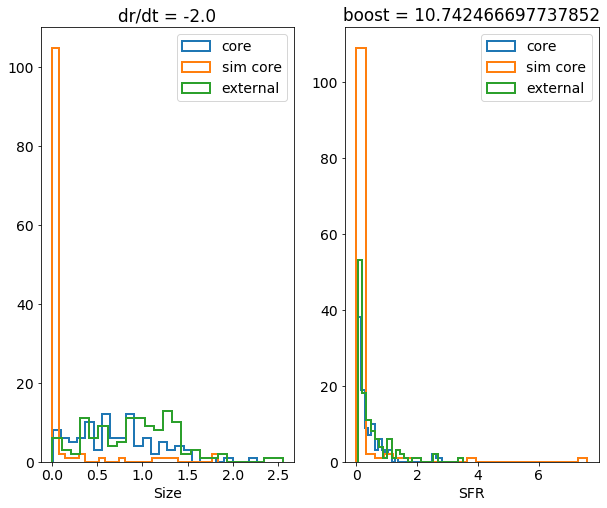

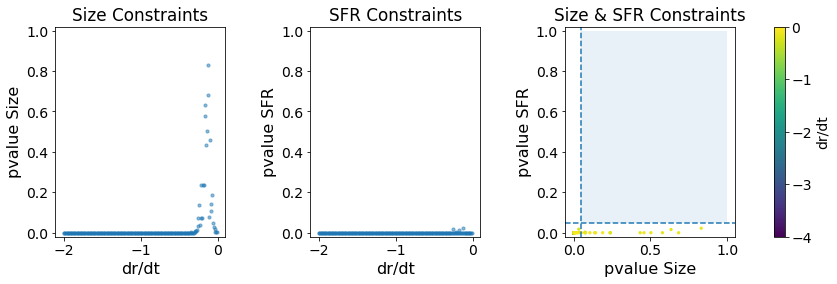

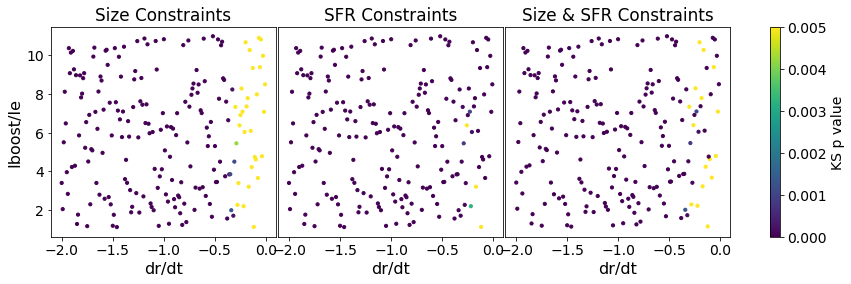

In [118]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py
tmax=3
all_drdt,all_p,all_p_sfr,all_boost,fquench_size,fquench_sfr=run_sim(model=1,drdtmin=-2,boostflag=True,maxboost=10,tmax=tmax,drdt_step=.01,nrandom=30,rmax=4,plotsingle=False,plotflag=True)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=1)
plot_boost_3panel(all_drdt,all_p,all_p_sfr, all_boost, tmax=3,v2=.005)

USING GSWLC SFRS

MIN SFR =  0.029785164294291896

Using 24um sizes (this is the right thing to do)


core vs external: size distribution
KS Test:
D =   0.27
p-vale = 1.387e-03 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   9.55
p-vale = 0.00017 (prob that samples are from same distribution)

core vs external: SFR distribution
KS Test:
D =   0.21
p-vale = 1.914e-02 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.37
p-vale = 0.51570 (prob that samples are from same distribution)

core vs external: Re 24
KS Test:
D =   0.26
p-vale = 1.737e-03 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   2.30
p-vale = 0.03645 (prob that samples are from same distribution)

core vs external: n sersic distribution
KS Test:
D =   0.10
p-vale = 6.216e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.90
p-vale = 0.90617 (prob that samples are from same distribution)

Wel

number of size = 0 : 75
number of size = 0 : 70
number of size = 0 : 72
number of size = 0 : 74
number of size = 0 : 68
number of size = 0 : 67
number of size = 0 : 66
number of size = 0 : 68
number of size = 0 : 72
number of size = 0 : 67
number of size = 0 : 70
number of size = 0 : 71
number of size = 0 : 69
number of size = 0 : 60
number of size = 0 : 62
number of size = 0 : 75
number of size = 0 : 73
number of size = 0 : 68
number of size = 0 : 70
number of size = 0 : 70
number of size = 0 : 64
number of size = 0 : 63
number of size = 0 : 65
number of size = 0 : 68
number of size = 0 : 74
number of size = 0 : 66
number of size = 0 : 66
number of size = 0 : 75
number of size = 0 : 74
number of size = 0 : 71
number of size = 0 : 71
number of size = 0 : 64
number of size = 0 : 69
number of size = 0 : 71
number of size = 0 : 63
number of size = 0 : 65
number of size = 0 : 62
number of size = 0 : 66
number of size = 0 : 59
number of size = 0 : 62
number of size = 0 : 60
number of size =

<Figure size 432x288 with 0 Axes>

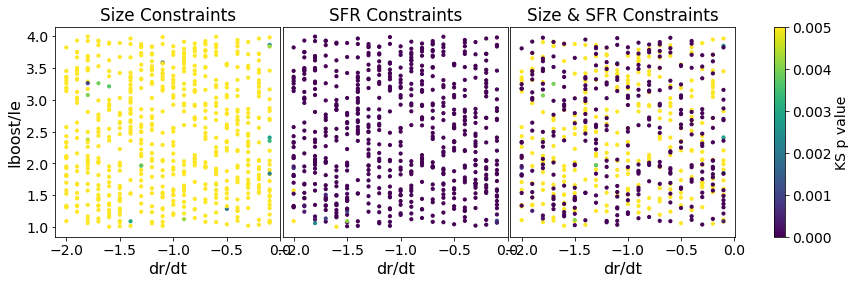

In [72]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py  --gsw
tmax=3
all_drdt,all_p,all_p_sfr,all_boost,fquench_size,fquench_sfr=run_sim(model=1,boostflag=True,tmax=tmax,drdt_step=.1,nrandom=30,rmax=4,plotsingle=False,plotflag=False)
plot_model3_3panel(all_drdt,all_p,all_p_sfr, all_boost, tmax=3,v2=.005)

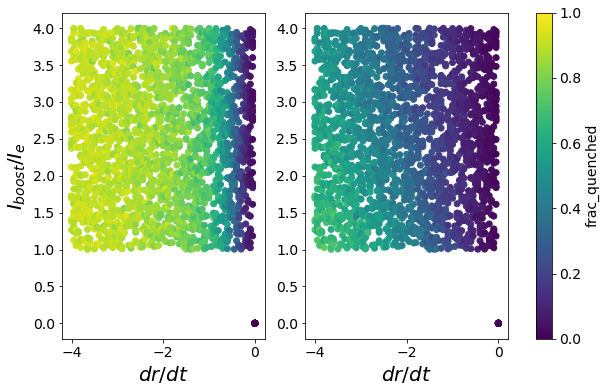

In [55]:
plt.figure(figsize=(10,6))
allax=[]
colors = [fquench_size, fquench_sfr]
for i in range(len(colors)):
    plt.subplot(1,2,i+1)
    plt.scatter(all_drdt,all_boost,c=colors[i],vmin=0,vmax=1)
    allax.append(plt.gca())
    plt.xlabel('$dr/dt$',fontsize=20)
    if i == 0:
        plt.ylabel('$I_{boost}/I_e$',fontsize=20)
plt.colorbar(ax=allax,label='frac_quenched')


This doesn't make sense.  If the galaxy drops out because the size is less than zero, then how is it not quenched for SFR as well?

Maybe need to make sure the sim_core sizes have a min value of zero before doing the integration.

KS Test:
D =   0.31
p-vale = 2.186e-05 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   5.02
p-vale = 0.00356 (prob that samples are from same distribution)


(0.3142857253551483, 2.1856218154425733e-05)

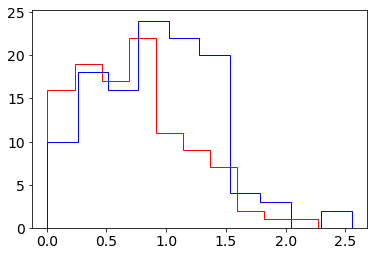

In [32]:
plt.figure()
plt.hist(core,histtype='step',color='r')
plt.hist(external,histtype='step',color='b')
lcommon.ks(core,external)

## Model 3, B/T cut, Spitzer SFRs ##

core vs external: size distribution
KS test: 0.20, p=8.09e-02
core vs external: SFR distribution
KS test: 0.09, p=8.65e-01
core vs external: n sersic distribution
KS test: 0.10, p=7.39e-01
Welcome!


<Figure size 432x288 with 0 Axes>

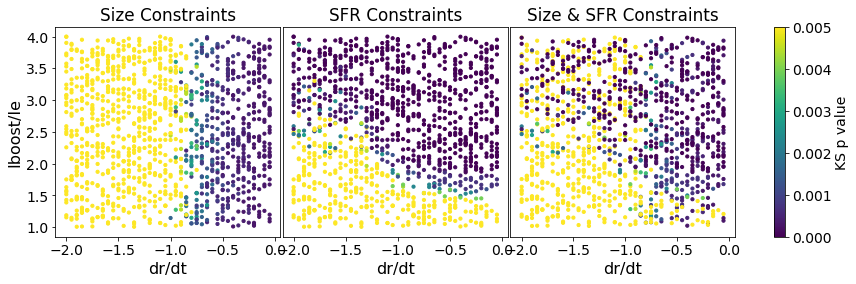

In [46]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 3 --tmax 3 --btcut
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr,boost=run_sim(tmax=tmax,drdt_step=.05,nrandom=30,rmax=4,plotsingle=False,plotflag=False)
plot_model3_3panel(all_drdt,all_p,all_p_sfr, boost, tmax=3,v2=.005)

## Model 3, no B/T cut, spitzer SFRs ##

core vs external: size distribution
KS test: 0.19, p=4.48e-02
core vs external: SFR distribution
KS test: 0.10, p=6.90e-01
core vs external: n sersic distribution
KS test: 0.09, p=8.02e-01
Welcome!


<Figure size 432x288 with 0 Axes>

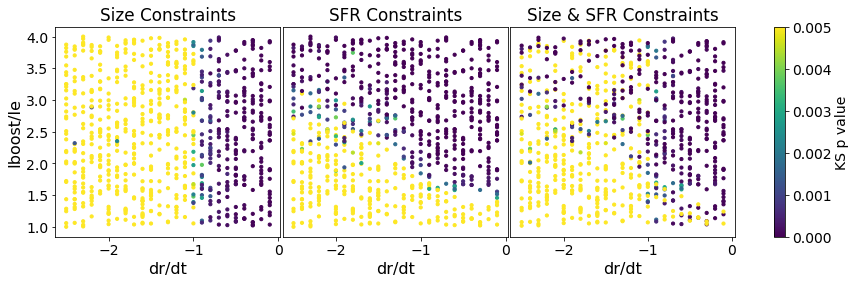

In [23]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 3 --tmax 3 --sfrint 1 
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr,boost=run_sim(tmax=tmax,drdt_step=.1,nrandom=30,rmax=4,plotsingle=False,plotflag=False)
plot_model3_3panel(all_drdt,all_p,all_p_sfr,boost,tmax=3)

# Using GSWLC SFRs #

* redoing simulations, but using GSWLC SFRs instead of the UV+IR SFRs we derive from MIPS 24um + GALEX NUV
  * we loose a few galaxies from the sample (XX out of YY)
  * but SFRs are probably more reliable, less scatter?
* going to run the following simulations

| Model |without B/T cut | with B/T cut |
|-------|------|----|
| Model 1 |   | |
| Model 2 | | |
| Model 3 | | |

USING GSWLC SFRS

Using 24um sizes (this is the right thing to do)


core vs external: size distribution
KS Test:
D =   0.18
p-vale = 1.469e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =   1.12
p-vale = 0.11230 (prob that samples are from same distribution)

core vs external: SFR distribution
KS Test:
D =   0.16
p-vale = 2.470e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.44
p-vale = 0.55065 (prob that samples are from same distribution)

core vs external: n sersic distribution
KS Test:
D =   0.19
p-vale = 1.088e-01 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  -0.64
p-vale = 0.68102 (prob that samples are from same distribution)

Welcome!


<Figure size 432x288 with 0 Axes>

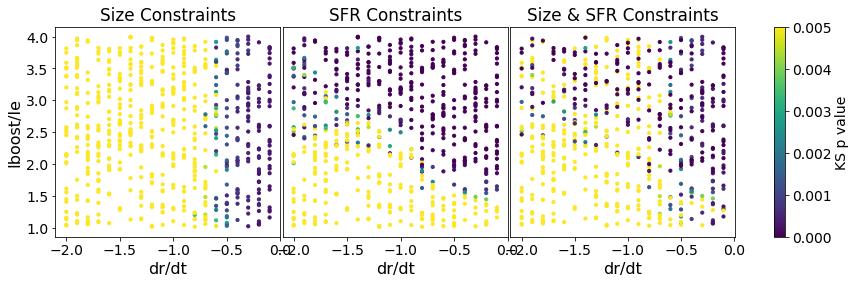

In [13]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --model 3 --tmax 3 --sfrint 1 --btcut --gsw
tmax=4
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr,boost=run_sim(tmax=tmax,drdt_step=.1,nrandom=30,rmax=4,plotsingle=False,plotflag=False)
plot_model3_3panel(all_drdt,all_p,all_p_sfr,boost,tmax=3)

core vs external: size distribution
KS test: 0.20, p=8.09e-02
core vs external: SFR distribution
KS test: 0.09, p=8.65e-01
core vs external: n sersic distribution
KS test: 0.10, p=7.39e-01
Welcome!
USING MODEL 2


<Figure size 432x288 with 0 Axes>

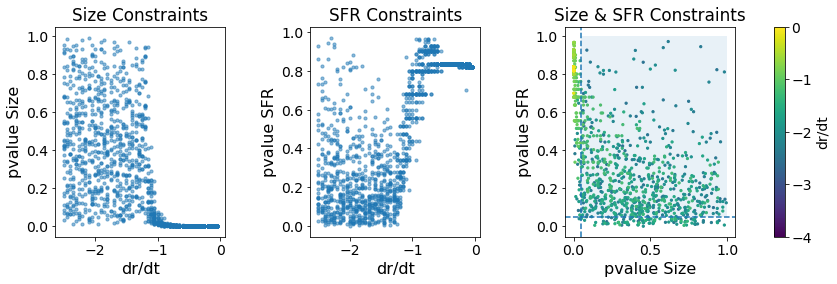

In [22]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 2 --tmax 3 --sfrint 1 --btcut --rmax 4
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr=run_sim(tmax=tmax,drdt_step=.05,rmax=4,nrandom=30,plotsingle=False,plotflag=False)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=2)

core vs external: size distribution
KS test: 0.20, p=8.09e-02
core vs external: SFR distribution
KS test: 0.09, p=8.65e-01
core vs external: n sersic distribution
KS test: 0.10, p=7.39e-01
Welcome!


<Figure size 432x288 with 0 Axes>

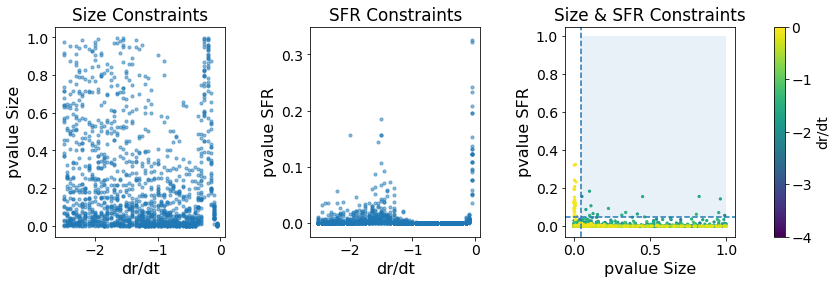

In [21]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/Python3/LCSsimulate-infall-paper2.py --use24 --model 1 --tmax 3 --sfrint 1 --btcut --rmax 4
tmax=3
best_drdt, best_sim_core,ks_p_max,all_drdt,all_p,all_p_sfr=run_sim(tmax=tmax,drdt_step=.05,rmax=4,nrandom=30,plotsingle=False,plotflag=False)
plot_model1_3panel(all_drdt,all_p,all_p_sfr,tmax=3,v2=.005,model=1)

# Cartoon Drawing of Models #

## Model 1 ##
* Sersic profile
* Re shrinks, everthing else stays the same



In [5]:
def sersic(x,Ie,n,Re):
    bn = 1.999*n - 0.327
    return Ie*np.exp(-1*bn*((x/Re)**(1./n)-1))
    

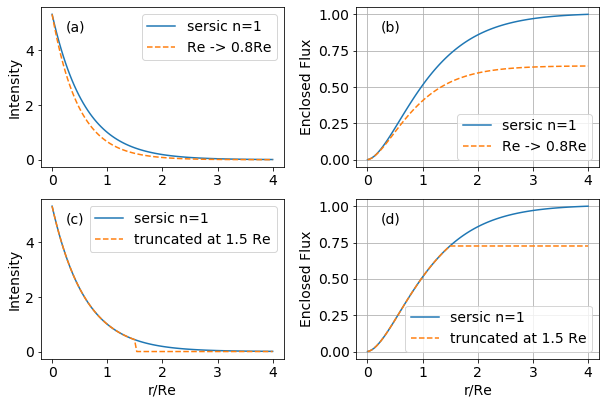

In [18]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=.3)

rmax = 4
scaleRe = 0.8
rtrunc = 1.5
n=1
# shrink Re
plt.subplot(3,2,1)
x = np.linspace(0,rmax,100)

Ie=1
Re=1
y = sersic(x,Ie,n,Re)
plt.plot(x,y,label='sersic n='+str(n))
y2 = sersic(x,Ie,n,scaleRe*Re)
plt.plot(x,y2,label="Re -> "+str(scaleRe)+"Re",ls='--')
#plt.legend()

plt.ylabel('Intensity')
plt.text(0.1,.85,'(a)',transform=plt.gca().transAxes,horizontalalignment='left')
plt.legend()

# plot total flux
plt.subplot(3,2,2)
dx = x[1]-x[0]
sum1 = (y*dx*2*np.pi*x)
sum2 = (y2*dx*2*np.pi*x)
plt.plot(x,np.cumsum(sum1)/np.max(np.cumsum(sum1)),label='sersic n='+str(n))
plt.plot(x,np.cumsum(sum2)/np.max(np.cumsum(sum1)),label="Re -> "+str(scaleRe)+"Re",ls='--')
plt.ylabel('Enclosed Flux')
plt.grid()
plt.text(0.1,.85,'(b)',transform=plt.gca().transAxes,horizontalalignment='left')
plt.legend()

# truncated sersic model
plt.subplot(3,2,3)
plt.plot(x,y,label='sersic n='+str(n))
y3 = y.copy()
flag = x > rtrunc
y3[flag] = np.zeros(sum(flag))
plt.plot(x,y3,ls='--',label='truncated at '+str(rtrunc)+' Re')
plt.legend()
plt.ylabel('Intensity')
#plt.legend()
#plt.gca().set_yscale('log')
plt.text(0.1,.85,'(c)',transform=plt.gca().transAxes,horizontalalignment='left')
plt.legend()
plt.xlabel('r/Re')

plt.subplot(3,2,4)
sum3 = (y3*dx*2*np.pi*x)
plt.plot(x,np.cumsum(sum1)/np.max(np.cumsum(sum1)),label='sersic n='+str(n))
plt.plot(x,np.cumsum(sum3)/np.max(np.cumsum(sum1)),label='truncated at '+str(rtrunc)+' Re',ls='--')
plt.ylabel('Enclosed Flux')

plt.grid()
plt.text(0.1,.85,'(d)',transform=plt.gca().transAxes,horizontalalignment='left')
plt.legend()
plt.xlabel('r/Re')
plt.savefig(plotdir+'/cartoon-models.png')
plt.savefig(plotdir+'/cartoon-models.pdf')
# need to show what measured Re would be in model 2

# truncated and boosted